In [1]:
# Reload dependencies upon changes
%load_ext autoreload
%autoreload 2

## Dependencies

In [1]:
from functools import partial
from itertools import product
from copy import deepcopy
import typing
import time
import sys
import pickle

import numpy as np
import gym
import tqdm
import matplotlib.pyplot as plt

from mazelab_experimenter import EnvRegister
from mazelab_experimenter import AgentShelve
from mazelab_experimenter import benchmark, GenericOuterHook, PredictionErrorHook, apply_trace
from mazelab_experimenter.utils import compute_optimal_value


# Result output format.
FILE_FORMAT = 'pdf'
OUTPUT_FORMAT = './figures/ablation_{}.' + FILE_FORMAT

print("Output figures will be formatted as:", OUTPUT_FORMAT.format("FILENAME"))

Output figures will be formatted as: ./figures/ablation_FILENAME.pdf


## Environment Definition

We explore simple gridworld environments presenting tabular features to the agents. We test our agents on an empty world and on a world with rooms, we keep the dimensionality small due to memory requirements incurred by either the hindsight tables or eligibility trace models.

The agents/ environments are initialized with a binary reward function, i.e., a function that always returns $0$ until a desired state is reached upon which it returns $1$.

In [2]:
t = 10_000  # Number of steps before terminating an episode for any agent on all environments.
# t = 1_000

name_grid10 = EnvRegister.register(
    maze_type='gridworld', 
    name=f'gridworld-v0', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(height=12, width=12),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[10, 10]]
    ),
    time_limit=t,
    override=True
)

name_grid20 = EnvRegister.register(
    maze_type='gridworld', 
    name=f'gridworld-v1', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(height=22, width=22),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[20, 20]]
    ),
    time_limit=t,
    override=True
)

name_rooms4 = EnvRegister.register(
    maze_type='n_rooms_square', 
    name=f'n_rooms-v0', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(num_rooms=4, room_size=5, gap_size=1),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[7, 7]]
    ),
    time_limit=t,
    override=True
)

name_rooms9 = EnvRegister.register(
    maze_type='n_rooms_square', 
    name=f'n_rooms-v1', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(num_rooms=9, room_size=5, gap_size=1),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[13, 13]]
    ),
    time_limit=t,
    override=True
)

name_mazeS = EnvRegister.register(
    maze_type='fixed_maze', 
    name=f'maze-v0', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(large=False),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[11, 11]]
    ),
    time_limit=t,
    override=True
)

name_mazeL = EnvRegister.register(
    maze_type='fixed_maze', 
    name=f'maze-v1', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(large=True),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[19, 19]]
    ),
    time_limit=t,
    override=True
)

# Collect each individual environment.
environment_names = [name_grid10, name_grid20, name_rooms4, name_rooms9, name_mazeS, name_mazeL]
environment_labels = ['10x10 Gridworld', '20x20 Gridworld', '4-rooms 5-to-1', '9-rooms 5-to-1', '10x10 Maze', '20x20 Maze']

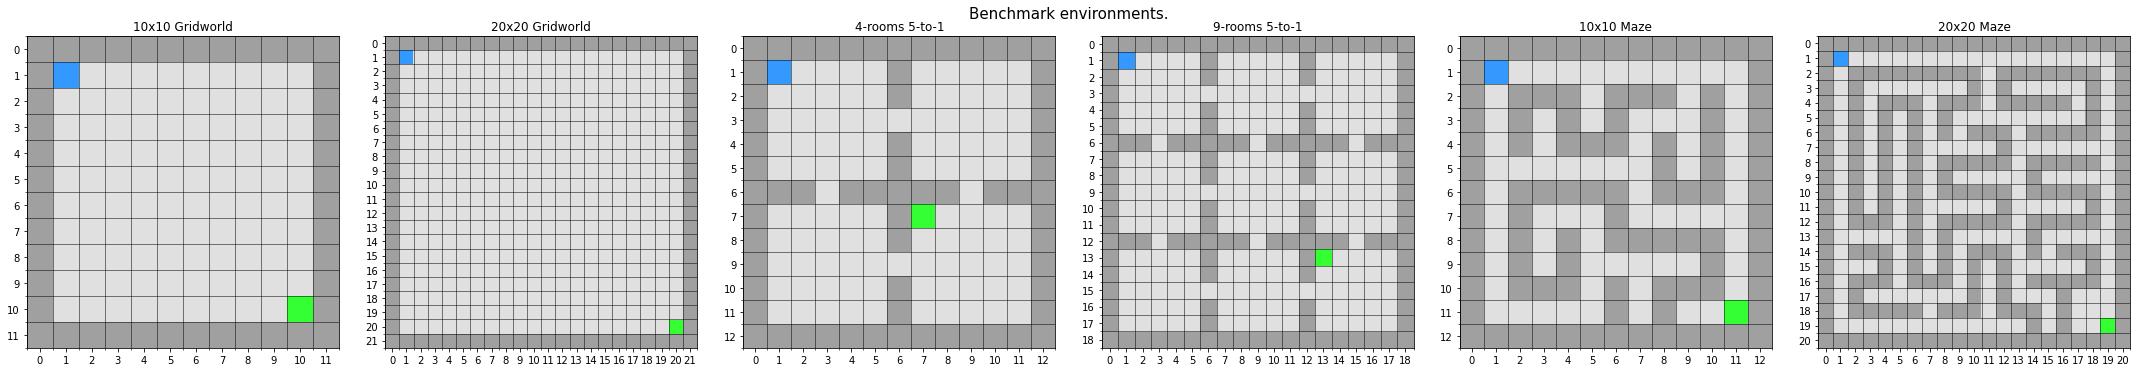

In [3]:
# Create and show an example visualization of the environment
dummy_images = list()
for name in environment_names:
    dummy = gym.make(name)
    dummy.reset()
    
    dummy_images.append(dummy.unwrapped.get_image())
    dummy.close()
    
fig, ax = plt.subplots(1, len(environment_names), figsize=(5 * len(environment_names), 5))
for i, img in enumerate(dummy_images):
    # Plot image with border padding
    ax[i].imshow(img)
    
    # Grid lines
    major, minor = np.arange(0, len(img), 1), np.arange(-.5, len(img), 1)
    ax[i].set_xticks(major); ax[i].set_yticks(major)            # Major plot ticks
    ax[i].set_xticklabels(major); ax[i].set_yticklabels(major)  # Major plot tick-labels
    ax[i].set_xticks(minor, minor=True); ax[i].set_yticks(minor, minor=True)  # Minor ticks for Grid-lines.
    
    ax[i].grid(which='minor', color='black', linestyle='-', linewidth=.5)
    
    # Annotations
    ax[i].set_title(environment_labels[i])

plt.suptitle("Benchmark environments.", fontsize=15)
plt.tight_layout()

plt.savefig(OUTPUT_FORMAT.format('BenchmarkEnvironment', FILE_FORMAT), format=FILE_FORMAT, bbox_inches="tight")
plt.show()

## Benchmark Functionality

For running the experiments, here we define helper functions that run various agent ablations over a variety of experimental parameters.

This includes functionality for logging the approximation error to the optimal Q-table. Every experiment makes use of the outlined interface.

In [4]:
def construct_prediction_hook(_env: gym.Env, agent, solution: np.ndarray = None) -> typing.List[PredictionErrorHook]:
    """ Helper function to construct a Q-max prediction error logger for a HierQV2 based agent. """
    if solution is None:
        solution = compute_optimal_value(_env)
        
    aggr = lambda arr, i: [i, np.mean(np.square(arr)), np.mean(np.abs(arr))]
    
    references = list()
    for i in range(agent.n_levels):    
        h_a = agent.atomic_horizons[i]
        
        solution_i = solution // h_a
        reference_i = agent.discount ** solution_i 
        
        reference_i[solution == 0] = 0
    
        references.append(reference_i)
    
    hooks = list()
    for i in range(agent.n_levels):
        getter = lambda agent, i: agent.critics[i].table[:, (agent._get_index(_env.unwrapped.maze.get_end_pos()[0]) 
                                                             if agent.critics[i].goal_conditioned else 0), :].max(axis=-1)
        
        hooks.append(PredictionErrorHook(references[i], partial(getter, i=i), partial(aggr, i=i)))
        
    return hooks


def run_benchmark(r: int, it: int, eps: int, trials: int, benchmark_environments: typing.List[str], 
                  ablation_generator: typing.Callable, log_value_error: bool = False, verbose: bool = True, 
                  **kwargs) -> typing.List[typing.Dict]:
    """ Helper function for running train-test experiments for numerous agents over a variety of experimental settings """
    benchmark_data = list()
    for env_name in benchmark_environments:
        print("=" * 50 + "\nExperiment environment:", env_name, end='\n\n')
        meta, agent_gens, separators = ablation_generator(env_name)

        if log_value_error:
            print("Constructing hooks...")
            dummy = gym.make(env_name)
            solution = compute_optimal_value(dummy)
            gen_hook = partial(construct_prediction_hook, _env=dummy, solution=solution)

        env_data = list()
        for i, (m, gen_a) in enumerate(zip(meta, agent_gens)):
            print(f"Benchmarking agent: {i+1}/{len(meta)} - ablation:", m)

            # Run the benchmark
            env_data.append(
                benchmark(
                    env_id=env_name, 
                    _agent_gen=gen_a, 
                    agent_test_kwargs=dict(behaviour_policy=False),
                    agent_train_kwargs=dict(),
                    skip_random_evaluation=True,
                    num_repetitions=r,
                    num_iterations=it,
                    num_episodes=eps,
                    num_trials=trials,
                    evaluation_hooks=([GenericOuterHook()] if (not log_value_error) else [GenericOuterHook(), *gen_hook(agent=gen_a())]),
                    verbose=verbose,
                    asynchronous=False,
                    **kwargs
                )
            )

        benchmark_data.append({'name': env_name, 'meta': meta, 'data': env_data, 'separators': separators})
        
    return benchmark_data


## Experiment Propagation Depth and Discount Balancing: Agent Definition 

Here we benchmark agents that use multistep returns for atomic and 2-level hierarchies. The ablation is done over a SARSA and Q-learning (with trace-cutting) $n$-step backup where the value for $n$ is set proportional to the hierarchical agents horizon. This is done to observe whether the hierarchical agents do something "smarter" than a $H \cdot n$-backup.

The ablation is as follows:
1. Stationary-filtering (True/False)
    - n-levels: 1 or 2
    - Backup: SARSA or Q-learning
    
- $H=3, n_{step}=\{1, 2, 3, 4, 8, T\}$
- $n_{atomic} = H \cdot n_{step}$
- $\gamma_{hier} = \gamma_{atomic}^H$

Only the smaller environments are used in this experiment to evaluate empirical differences over the ablations, not to reach an exhaustive performance comparison (see next experiment).

In [5]:
# Shared Keyword arguments
shared_kwargs = {
    'epsilon': 0.25,
    'lr': 1.0,
    'greedy_options': True,
    'greedy_training': True
}

# Defaults for Hierarchical agents.
hierarchical_defaults = {
    'horizons': 3,
    'relative_actions': True,
    'universal_top': False
}


def create_agent_generator(_env: gym.Env, **kwargs) -> typing.Callable:
    """ Helper function for instantiating agents with a fixed goal given some environment. 
    
    Tries to keep propagation length between flat and hierarchical agents equivalent.
    N-step is H * n if flat, and n if hierarchical.
    """
    agent = AgentShelve.retrieve(
        agent='HierQN',  
        keyword_arguments=dict(
            observation_shape=_env.observation_space.shape,
            n_actions=_env.action_space.n,
            **kwargs, **hierarchical_defaults, **shared_kwargs
        ))
    agent.set_goal(agent._get_index(_env.unwrapped.maze.get_end_pos()[0]))   
    return agent


def get_environment_agent_ablations(_env_name: str, ablation_grid: typing.Dict) -> typing.List[typing.Generator]:
    """ Helper function for creating agent generators with an environment dependency over a grid of parameters. """
    dummy = gym.make(_env_name)
    
    # Unpack all ablation-runs over their parameter grid into flat lists.
    meta, agent_generators, separators = list(), list(), list()
    for name, ablations in ablations_grid.items():
        # Take cartesian product of all specified parameter options.
        keys, values = zip(*ablations.items())
        grid = [dict(zip(keys, v)) for v in product(*values)]
        
        # Initialize agents.
        for p in grid:
            gen = partial(create_agent_generator, _env=dummy, **p)
       
            # Add agent generator and ablation metadata to global execution list.        
            agent_generators.append(gen)
            meta.append(p)
        
        # Append grid length to separate list for slicing convenience.
        separators.append(len(grid))
        
    return meta, agent_generators, separators
        

# Define (ad-hoc) Parameter Ablation Grid and wrap into generator function.
ablations_grid = {
    'multistep_flat': {'n_steps': [3, 6, 9, 12, t], 'n_levels': [1], 'discount': [0.95], 'sarsa': [True, False], 'stationary_filtering': [True, False]},
    'multistep_hierarchical': {'n_steps': [1, 2, 3, 4, t], 'n_levels': [2], 'discount': [0.86], 'sarsa': [True, False], 'stationary_filtering': [True, False]}
}
# Use this function with an environment arguments to get all agents specified by the parameter grid as generators.
# >> meta, agents, seps = get_environment_ablations(env_name)
get_environment_ablations = partial(get_environment_agent_ablations, ablation_grid=ablations_grid)

### Run Benchmark & IO

**Run Small Environments**

In [10]:
for e in environment_names[0::2]:  # The small environments
    # Benchmark configuration and execution.
    small_benchmark_data = run_benchmark(
        r=10,
        it=50,
        eps=1,
        trials=1,
        benchmark_environments=[e],  
        ablation_generator=get_environment_ablations,
        log_value_error=True,
        verbose=True
    )
    with open(f'GT_propagation_ablation_{e}_{int(time.time())}.out', 'wb') as f:
        pickle.dump(small_benchmark_data, f)


Experiment environment: gridworld-v0

Constructing hooks...
Benchmarking agent: 1/40 - ablation: {'n_steps': 3, 'n_levels': 1, 'discount': 0.95, 'sarsa': True, 'stationary_filtering': True}
-- Benchmarking Repetition 1 / 10 --- ETA:  --- Rate: 0 sec/ it --- Total: 0.00 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.90it/s]
-- Benchmarking Repetition 2 / 10 --- ETA: 0:01:16 --- Rate: 8 sec/ it --- Total: 0.14 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.03it/s]
-- Benchmarking Repetition 3 / 10 --- ETA: 0:01:02 --- Rate: 7 sec/ it --- Tota

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 108.46it/s]
-- Benchmarking Repetition 2 / 10 --- ETA: 0:00:04 --- Rate: 0 sec/ it --- Total: 0.01 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 97.47it/s]
-- Benchmarking Repetition 3 / 10 --- ETA: 0:00:03 --- Rate: 0 sec/ it --- Total: 0.02 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00, 10.00it/s]
-- Benchmarking Repetition 3 / 10 --- ETA: 0:00:33 --- Rate: 4 sec/ it --- Total: 0.14 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.41it/s]
-- Benchmarking Repetition 4 / 10 --- ETA: 0:00:35 --- Rate: 5 sec/ it --- Total: 0.25 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 125.94it/s]
-- Benchmarking Repetition 4 / 10 --- ETA: 0:00:02 --- Rate: 0 sec/ it --- Total: 0.02 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 116.28it/s]
-- Benchmarking Repetition 5 / 10 --- ETA: 0:00:02 --- Rate: 0 sec/ it --- Total: 0.03 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.22it/s]
-- Benchmarking Repetition 5 / 10 --- ETA: 0:00:41 --- Rate: 6 sec/ it --- Total: 0.46 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.96it/s]
-- Benchmarking Repetition 6 / 10 --- ETA: 0:00:32 --- Rate: 6 sec/ it --- Total: 0.54 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 103.73it/s]
-- Benchmarking Repetition 6 / 10 --- ETA: 0:00:02 --- Rate: 0 sec/ it --- Total: 0.04 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.30it/s]
-- Benchmarking Repetition 7 / 10 --- ETA: 0:00:02 --- Rate: 0 sec/ it --- Total: 0.05 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.32it/s]
-- Benchmarking Repetition 7 / 10 --- ETA: 0:00:22 --- Rate: 5 sec/ it --- Total: 0.55 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.85it/s]
-- Benchmarking Repetition 8 / 10 --- ETA: 0:00:15 --- Rate: 5 sec/ it --- Total: 0.61 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 97.00it/s]
-- Benchmarking Repetition 8 / 10 --- ETA: 0:00:02 --- Rate: 0 sec/ it --- Total: 0.08 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 68.12it/s]
-- Benchmarking Repetition 9 / 10 --- ETA: 0:00:01 --- Rate: 0 sec/ it --- Total: 0.09 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.86it/s]
-- Benchmarking Repetition 9 / 10 --- ETA: 0:05:03 --- Rate: 151 sec/ it --- Total: 20.21 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]
-- Benchmarking Repetition 10 / 10 --- ETA: 0:02:21 --- Rate: 141 sec/ it --- Total: 21.20 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.66it/s]
-- Benchmarking Repetition 10 / 10 --- ETA: 0:00:04 --- Rate: 4 sec/ it --- Total: 0.66 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.74it/s]
Benchmarking agent: 20/40 - ablation: {'n_steps': 10000, 'n_levels': 1, 'discount': 0.95, 'sarsa': False, 'stationary_filtering': False}
-- Benchmarking Repetition 1 / 10 --- ETA:  --- Rate: 0 sec/ it --- Total: 0.00 min
Train-Test loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.57it/s]
Benchmarking agent: 22/40 - ablation: {'n_steps': 1, 'n_levels': 2, 'discount': 0.86, 'sarsa': True, 'stationary_filtering': False}
-- Benchmarking Repetition 1 / 10 --- ETA:  --- Rate: 0 sec/ it --- Total: 0.00 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 34.40it/s]
-- Benchmarking Repetition 2 / 10 --- ETA: 0:00:13 --- Rate: 1 sec/ it --- Total: 0.02 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 74.08it/s]
-- Benchmarking Repetition 2 / 10 --- ETA: 0:00:06 --- Rate: 0 sec/ it --- Total: 0.01 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.38it/s]
-- Benchmarking Repetition 3 / 10 --- ETA: 0:00:05 --- Rate: 0 sec/ it --- Total: 0.02 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00

KeyboardInterrupt: 

## Experiment Performance Multi-Step Returns: Agent Definition 

For benchmarking the agents we utilize two types of implemented classes for either the flat or the hierarchical agents. These are the atomic and compound update types, note that an atomic 1-step update $\equiv$ to a $\lambda=0$ compound update which is just 1-step $TD$. For $\lambda=0$ we can fall back to the multi-step implementation with $n=1$ for simplicity, we test out both methods to assert empirical equivalence.

In [6]:
# Shared Keyword arguments
shared_kwargs = {
    'epsilon': 0.25,
    'discount': 0.95,
    'lr': 1.0
}

# Defaults for Hierarchical agents.
hierarchical_defaults = {
    'horizons': 3,
    'relative_actions': True,
    'universal_top': False
}


def create_agent_generator(_env: gym.Env, atomic: bool, **kwargs) -> typing.Callable:
    """ Helper function for instantiating agents with a fixed goal given some environment. 
    
    Atomic implies n-step returns, otherwise implies compound/ lambda returns.
    Hierarchical denotes whether to use a hierarchical Q-learner or a flat agent.
    
    Actual agent hyperparameters 'v' should be specified outside this function.
    """
    agent = AgentShelve.retrieve(
        agent=('HierQN' if atomic else 'HierQLambda'),  
        keyword_arguments=dict(
            observation_shape=_env.observation_space.shape,
            n_actions=_env.action_space.n,
            **kwargs, **hierarchical_defaults, **shared_kwargs
        ))
    agent.set_goal(agent._get_index(_env.unwrapped.maze.get_end_pos()[0]))   
    return agent


def get_environment_agent_ablations(_env_name: str, ablation_grid: typing.Dict) -> typing.List[typing.Generator]:
    """ Helper function for creating agent generators with an environment dependency over a grid of parameters. """
    dummy = gym.make(_env_name)
    
    # Unpack all ablation-runs over their parameter grid into flat lists.
    meta, agent_generators, separators = list(), list(), list()
    for name, ablations in ablations_grid.items():
        # Take cartesian product of all specified parameter options.
        keys, values = zip(*ablations.items())
        grid = [dict(zip(keys, v)) for v in product(*values)]
        
        # Initialize agents.
        for p in grid:
            gen = partial(create_agent_generator, _env=dummy, **p)
       
            # Add agent generator and ablation metadata to global execution list.        
            agent_generators.append(gen)
            meta.append(p)
        
        # Append grid length to separate list for slicing convenience.
        separators.append(len(grid))
        
    return meta, agent_generators, separators
        

# Define (ad-hoc) Parameter Ablation Grid and wrap into generator function.
ablations_grid = {
    'lambda': {'atomic': [False], 'decay': [0.0, 0.5, 0.8, 1.0], 'n_levels': [4, 3, 2, 1], 'greedy_options': [True]},
    'multistep_hierarchical': {'atomic': [True], 'n_steps': [1, 3, 5, 8], 'n_levels': [4, 3, 2, 1], 'greedy_options': [True]}
}
# Use this function with an environment arguments to get all agents specified by the parameter grid as generators.
# >> meta, agents, seps = get_environment_ablations(env_name)
get_environment_ablations = partial(get_environment_agent_ablations, ablation_grid=ablations_grid)

### Run Benchmark & IO

**Run Small Environments**

In [7]:
r = 50

for e in environment_names[::2]:  # The small environments
    # Benchmark configuration and execution.
    small_benchmark_data = run_benchmark(
        r=r,
        it=50,
        eps=1,
        trials=1,
        benchmark_environments=[e],  
        ablation_generator=get_environment_ablations,
        verbose=True
    )

    with open(f'GT_performance_ablation_{e}_{int(time.time())}.out', 'wb') as f:
        pickle.dump(small_benchmark_data, f)
    

Experiment environment: gridworld-v0

Benchmarking agent: 1/32 - ablation: {'atomic': False, 'decay': 0.0, 'n_levels': 4, 'greedy_options': True}
-- Benchmarking Repetition 1 / 50 --- ETA:  --- Rate: 0 sec/ it --- Total: 0.00 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.19it/s]
-- Benchmarking Repetition 2 / 50 --- ETA: 0:01:45 --- Rate: 2 sec/ it --- Total: 0.04 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 24.63it/s]
-- Benchmarking Repetition 3 / 50 --- ETA: 0:01:40 --- Rate: 2 sec/ it --- Total: 0.07 min
Train-Test loop: 100%|██████████

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.96it/s]
-- Benchmarking Repetition 23 / 50 --- ETA: 0:01:06 --- Rate: 2 sec/ it --- Total: 0.87 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.87it/s]
-- Benchmarking Repetition 24 / 50 --- ETA: 0:01:03 --- Rate: 2 sec/ it --- Total: 0.90 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.92it/s]
-- Benchmarking Repetition 45 / 50 --- ETA: 0:00:14 --- Rate: 2 sec/ it --- Total: 1.80 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.48it/s]
-- Benchmarking Repetition 46 / 50 --- ETA: 0:00:12 --- Rate: 2 sec/ it --- Total: 1.85 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.18it/s]
-- Benchmarking Repetition 17 / 50 --- ETA: 0:00:46 --- Rate: 1 sec/ it --- Total: 0.37 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 35.27it/s]
-- Benchmarking Repetition 18 / 50 --- ETA: 0:00:45 --- Rate: 1 sec/ it --- Total: 0.39 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 40.25it/s]
-- Benchmarking Repetition 39 / 50 --- ETA: 0:00:16 --- Rate: 1 sec/ it --- Total: 0.87 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.01it/s]
-- Benchmarking Repetition 40 / 50 --- ETA: 0:00:15 --- Rate: 1 sec/ it --- Total: 0.91 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 71.19it/s]
-- Benchmarking Repetition 11 / 50 --- ETA: 0:00:32 --- Rate: 0 sec/ it --- Total: 0.13 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 58.57it/s]
-- Benchmarking Repetition 12 / 50 --- ETA: 0:00:31 --- Rate: 0 sec/ it --- Total: 0.15 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 51.76it/s]
-- Benchmarking Repetition 33 / 50 --- ETA: 0:00:16 --- Rate: 0 sec/ it --- Total: 0.48 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.02it/s]
-- Benchmarking Repetition 34 / 50 --- ETA: 0:00:15 --- Rate: 0 sec/ it --- Total: 0.49 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 61.96it/s]
-- Benchmarking Repetition 5 / 50 --- ETA: 0:00:41 --- Rate: 0 sec/ it --- Total: 0.06 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 42.20it/s]
-- Benchmarking Repetition 6 / 50 --- ETA: 0:00:43 --- Rate: 0 sec/ it --- Total: 0.08 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 53.22it/s]
-- Benchmarking Repetition 27 / 50 --- ETA: 0:00:21 --- Rate: 0 sec/ it --- Total: 0.40 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 64.87it/s]
-- Benchmarking Repetition 28 / 50 --- ETA: 0:00:20 --- Rate: 0 sec/ it --- Total: 0.41 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 54.71it/s]
-- Benchmarking Repetition 49 / 50 --- ETA: 0:00:01 --- Rate: 0 sec/ it --- Total: 0.71 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 64.25it/s]
-- Benchmarking Repetition 50 / 50 --- ETA: 0:00:00 --- Rate: 0 sec/ it --- Total: 0.72 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 16.69it/s]
-- Benchmarking Repetition 21 / 50 --- ETA: 0:01:10 --- Rate: 2 sec/ it --- Total: 0.78 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.71it/s]
-- Benchmarking Repetition 22 / 50 --- ETA: 0:01:09 --- Rate: 2 sec/ it --- Total: 0.83 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.65it/s]
-- Benchmarking Repetition 43 / 50 --- ETA: 0:00:19 --- Rate: 2 sec/ it --- Total: 1.71 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 24.25it/s]
-- Benchmarking Repetition 44 / 50 --- ETA: 0:00:17 --- Rate: 2 sec/ it --- Total: 1.74 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 43.06it/s]
-- Benchmarking Repetition 15 / 50 --- ETA: 0:00:50 --- Rate: 1 sec/ it --- Total: 0.33 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.36it/s]
-- Benchmarking Repetition 16 / 50 --- ETA: 0:00:49 --- Rate: 1 sec/ it --- Total: 0.36 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 44.04it/s]
-- Benchmarking Repetition 37 / 50 --- ETA: 0:00:18 --- Rate: 1 sec/ it --- Total: 0.79 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 63.40it/s]
-- Benchmarking Repetition 38 / 50 --- ETA: 0:00:16 --- Rate: 1 sec/ it --- Total: 0.80 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 67.09it/s]
-- Benchmarking Repetition 9 / 50 --- ETA: 0:00:30 --- Rate: 0 sec/ it --- Total: 0.10 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 87.20it/s]
-- Benchmarking Repetition 10 / 50 --- ETA: 0:00:28 --- Rate: 0 sec/ it --- Total: 0.11 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 77.85it/s]
-- Benchmarking Repetition 31 / 50 --- ETA: 0:00:13 --- Rate: 0 sec/ it --- Total: 0.35 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.83it/s]
-- Benchmarking Repetition 32 / 50 --- ETA: 0:00:13 --- Rate: 0 sec/ it --- Total: 0.38 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 202.44it/s]
-- Benchmarking Repetition 3 / 50 --- ETA: 0:00:13 --- Rate: 0 sec/ it --- Total: 0.01 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 181.52it/s]
-- Benchmarking Repetition 4 / 50 --- ETA: 0:00:13 --- Rate: 0 sec/ it --- Total: 0.01 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 187.85it/s]
-- Benchmarking Repetition 25 / 50 --- ETA: 0:00:08 --- Rate: 0 sec/ it --- Total: 0.13 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.62it/s]
-- Benchmarking Repetition 26 / 50 --- ETA: 0:00:08 --- Rate: 0 sec/ it --- Total: 0.13 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 196.47it/s]
-- Benchmarking Repetition 47 / 50 --- ETA: 0:00:01 --- Rate: 0 sec/ it --- Total: 0.25 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.00it/s]
-- Benchmarking Repetition 48 / 50 --- ETA: 0:00:00 --- Rate: 0 sec/ it --- Total: 0.25 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.06it/s]
-- Benchmarking Repetition 19 / 50 --- ETA: 0:01:34 --- Rate: 2 sec/ it --- Total: 0.89 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.75it/s]
-- Benchmarking Repetition 20 / 50 --- ETA: 0:01:31 --- Rate: 2 sec/ it --- Total: 0.93 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.60it/s]
-- Benchmarking Repetition 41 / 50 --- ETA: 0:00:26 --- Rate: 2 sec/ it --- Total: 1.77 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.59it/s]
-- Benchmarking Repetition 42 / 50 --- ETA: 0:00:23 --- Rate: 2 sec/ it --- Total: 1.81 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 35.31it/s]
-- Benchmarking Repetition 13 / 50 --- ETA: 0:01:06 --- Rate: 1 sec/ it --- Total: 0.35 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.53it/s]
-- Benchmarking Repetition 14 / 50 --- ETA: 0:01:08 --- Rate: 1 sec/ it --- Total: 0.40 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.94it/s]
-- Benchmarking Repetition 35 / 50 --- ETA: 0:00:24 --- Rate: 1 sec/ it --- Total: 0.86 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 44.02it/s]
-- Benchmarking Repetition 36 / 50 --- ETA: 0:00:22 --- Rate: 1 sec/ it --- Total: 0.88 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 86.52it/s]
-- Benchmarking Repetition 7 / 50 --- ETA: 0:00:32 --- Rate: 0 sec/ it --- Total: 0.07 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 59.69it/s]
-- Benchmarking Repetition 8 / 50 --- ETA: 0:00:32 --- Rate: 0 sec/ it --- Total: 0.09 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 86.84it/s]
-- Benchmarking Repetition 29 / 50 --- ETA: 0:00:17 --- Rate: 0 sec/ it --- Total: 0.37 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 72.50it/s]
-- Benchmarking Repetition 30 / 50 --- ETA: 0:00:16 --- Rate: 0 sec/ it --- Total: 0.38 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 88.01it/s]
Benchmarking agent: 12/32 - ablation: {'atomic': False, 'decay': 0.8, 'n_levels': 1, 'greedy_options': True}
-- Benchmarking Repetition 1 / 50 --- ETA:  --- Rate: 0 sec/ it --- Total: 0.00 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 160.26it/s]
-- Benchmarking Repetition 2 / 50 --- ETA: 0:00:15 --- Rate: 0 sec/ it --- Total: 0.01 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.28it/s]
-- Benchmarking Repetition 23 / 50 --- ETA: 0:00:08 --- Rate: 0 sec/ it --- Total: 0.11 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.76it/s]
-- Benchmarking Repetition 24 / 50 --- ETA: 0:00:08 --- Rate: 0 sec/ it --- Total: 0.12 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 170.77it/s]
-- Benchmarking Repetition 45 / 50 --- ETA: 0:00:01 --- Rate: 0 sec/ it --- Total: 0.22 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 130.55it/s]
-- Benchmarking Repetition 46 / 50 --- ETA: 0:00:01 --- Rate: 0 sec/ it --- Total: 0.23 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.71it/s]
-- Benchmarking Repetition 17 / 50 --- ETA: 0:01:29 --- Rate: 2 sec/ it --- Total: 0.70 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.83it/s]
-- Benchmarking Repetition 18 / 50 --- ETA: 0:01:28 --- Rate: 2 sec/ it --- Total: 0.76 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.30it/s]
-- Benchmarking Repetition 39 / 50 --- ETA: 0:00:30 --- Rate: 2 sec/ it --- Total: 1.60 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.70it/s]
-- Benchmarking Repetition 40 / 50 --- ETA: 0:00:27 --- Rate: 2 sec/ it --- Total: 1.63 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 43.75it/s]
-- Benchmarking Repetition 11 / 50 --- ETA: 0:00:51 --- Rate: 1 sec/ it --- Total: 0.21 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 39.92it/s]
-- Benchmarking Repetition 12 / 50 --- ETA: 0:00:49 --- Rate: 1 sec/ it --- Total: 0.23 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 31.07it/s]
-- Benchmarking Repetition 33 / 50 --- ETA: 0:00:27 --- Rate: 1 sec/ it --- Total: 0.82 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 48.36it/s]
-- Benchmarking Repetition 34 / 50 --- ETA: 0:00:26 --- Rate: 1 sec/ it --- Total: 0.84 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 67.07it/s]
-- Benchmarking Repetition 5 / 50 --- ETA: 0:00:41 --- Rate: 0 sec/ it --- Total: 0.06 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 37.78it/s]
-- Benchmarking Repetition 6 / 50 --- ETA: 0:00:44 --- Rate: 0 sec/ it --- Total: 0.08 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 83.35it/s]
-- Benchmarking Repetition 27 / 50 --- ETA: 0:00:20 --- Rate: 0 sec/ it --- Total: 0.37 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 85.11it/s]
-- Benchmarking Repetition 28 / 50 --- ETA: 0:00:19 --- Rate: 0 sec/ it --- Total: 0.38 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 49.23it/s]
-- Benchmarking Repetition 49 / 50 --- ETA: 0:00:01 --- Rate: 0 sec/ it --- Total: 0.64 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 85.79it/s]
-- Benchmarking Repetition 50 / 50 --- ETA: 0:00:00 --- Rate: 0 sec/ it --- Total: 0.65 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 197.07it/s]
-- Benchmarking Repetition 21 / 50 --- ETA: 0:00:08 --- Rate: 0 sec/ it --- Total: 0.10 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.79it/s]
-- Benchmarking Repetition 22 / 50 --- ETA: 0:00:08 --- Rate: 0 sec/ it --- Total: 0.10 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 198.35it/s]
-- Benchmarking Repetition 43 / 50 --- ETA: 0:00:02 --- Rate: 0 sec/ it --- Total: 0.20 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 180.40it/s]
-- Benchmarking Repetition 44 / 50 --- ETA: 0:00:01 --- Rate: 0 sec/ it --- Total: 0.20 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.97it/s]
-- Benchmarking Repetition 15 / 50 --- ETA: 0:01:05 --- Rate: 1 sec/ it --- Total: 0.42 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.23it/s]
-- Benchmarking Repetition 16 / 50 --- ETA: 0:01:03 --- Rate: 1 sec/ it --- Total: 0.45 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.87it/s]
-- Benchmarking Repetition 37 / 50 --- ETA: 0:00:25 --- Rate: 1 sec/ it --- Total: 1.10 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 34.48it/s]
-- Benchmarking Repetition 38 / 50 --- ETA: 0:00:23 --- Rate: 1 sec/ it --- Total: 1.13 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.47it/s]
-- Benchmarking Repetition 9 / 50 --- ETA: 0:00:52 --- Rate: 1 sec/ it --- Total: 0.17 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 53.51it/s]
-- Benchmarking Repetition 10 / 50 --- ETA: 0:00:49 --- Rate: 1 sec/ it --- Total: 0.18 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 59.30it/s]
-- Benchmarking Repetition 31 / 50 --- ETA: 0:00:22 --- Rate: 1 sec/ it --- Total: 0.57 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 44.71it/s]
-- Benchmarking Repetition 32 / 50 --- ETA: 0:00:21 --- Rate: 1 sec/ it --- Total: 0.59 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 51.99it/s]
-- Benchmarking Repetition 3 / 50 --- ETA: 0:00:42 --- Rate: 0 sec/ it --- Total: 0.03 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 68.78it/s]
-- Benchmarking Repetition 4 / 50 --- ETA: 0:00:39 --- Rate: 0 sec/ it --- Total: 0.04 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 59.36it/s]
-- Benchmarking Repetition 25 / 50 --- ETA: 0:00:19 --- Rate: 0 sec/ it --- Total: 0.31 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 70.94it/s]
-- Benchmarking Repetition 26 / 50 --- ETA: 0:00:19 --- Rate: 0 sec/ it --- Total: 0.32 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 55.01it/s]
-- Benchmarking Repetition 47 / 50 --- ETA: 0:00:03 --- Rate: 0 sec/ it --- Total: 0.65 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 58.51it/s]
-- Benchmarking Repetition 48 / 50 --- ETA: 0:00:02 --- Rate: 0 sec/ it --- Total: 0.66 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 67.98it/s]
-- Benchmarking Repetition 19 / 50 --- ETA: 0:00:25 --- Rate: 0 sec/ it --- Total: 0.24 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 52.53it/s]
-- Benchmarking Repetition 20 / 50 --- ETA: 0:00:24 --- Rate: 0 sec/ it --- Total: 0.25 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 65.06it/s]
-- Benchmarking Repetition 41 / 50 --- ETA: 0:00:08 --- Rate: 0 sec/ it --- Total: 0.54 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 66.08it/s]
-- Benchmarking Repetition 42 / 50 --- ETA: 0:00:07 --- Rate: 0 sec/ it --- Total: 0.55 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 54.34it/s]
-- Benchmarking Repetition 13 / 50 --- ETA: 0:00:58 --- Rate: 1 sec/ it --- Total: 0.31 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.57it/s]
-- Benchmarking Repetition 14 / 50 --- ETA: 0:00:58 --- Rate: 1 sec/ it --- Total: 0.34 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 47.53it/s]
-- Benchmarking Repetition 35 / 50 --- ETA: 0:00:28 --- Rate: 1 sec/ it --- Total: 1.02 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.53it/s]
-- Benchmarking Repetition 36 / 50 --- ETA: 0:00:30 --- Rate: 2 sec/ it --- Total: 1.17 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 60.55it/s]
-- Benchmarking Repetition 7 / 50 --- ETA: 0:00:45 --- Rate: 1 sec/ it --- Total: 0.10 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 57.74it/s]
-- Benchmarking Repetition 8 / 50 --- ETA: 0:00:43 --- Rate: 1 sec/ it --- Total: 0.12 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.58it/s]
-- Benchmarking Repetition 29 / 50 --- ETA: 0:00:23 --- Rate: 1 sec/ it --- Total: 0.49 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 41.46it/s]
-- Benchmarking Repetition 30 / 50 --- ETA: 0:00:22 --- Rate: 1 sec/ it --- Total: 0.52 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 41.66it/s]
Benchmarking agent: 23/32 - ablation: {'atomic': True, 'n_steps': 3, 'n_levels': 2, 'greedy_options': True}
-- Benchmarking Repetition 1 / 50 --- ETA:  --- Rate: 0 sec/ it --- Total: 0.00 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 60.61it/s]
-- Benchmarking Repetition 2 / 50 --- ETA: 0:00:40 --- Rate: 0 sec/ it --- Total: 0.01 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 63.84it/s]
-- Benchmarking Repetition 23 / 50 --- ETA: 0:00:23 --- Rate: 0 sec/ it --- Total: 0.31 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 58.20it/s]
-- Benchmarking Repetition 24 / 50 --- ETA: 0:00:22 --- Rate: 0 sec/ it --- Total: 0.32 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 53.89it/s]
-- Benchmarking Repetition 45 / 50 --- ETA: 0:00:05 --- Rate: 0 sec/ it --- Total: 0.63 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 59.39it/s]
-- Benchmarking Repetition 46 / 50 --- ETA: 0:00:04 --- Rate: 0 sec/ it --- Total: 0.65 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 97.46it/s]
-- Benchmarking Repetition 17 / 50 --- ETA: 0:00:18 --- Rate: 0 sec/ it --- Total: 0.15 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 122.06it/s]
-- Benchmarking Repetition 18 / 50 --- ETA: 0:00:17 --- Rate: 0 sec/ it --- Total: 0.15 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 122.26it/s]
-- Benchmarking Repetition 39 / 50 --- ETA: 0:00:06 --- Rate: 0 sec/ it --- Total: 0.32 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 96.03it/s]
-- Benchmarking Repetition 40 / 50 --- ETA: 0:00:05 --- Rate: 0 sec/ it --- Total: 0.33 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.76it/s]
-- Benchmarking Repetition 11 / 50 --- ETA: 0:02:12 --- Rate: 3 sec/ it --- Total: 0.55 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.24it/s]
-- Benchmarking Repetition 12 / 50 --- ETA: 0:02:02 --- Rate: 3 sec/ it --- Total: 0.58 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 54.55it/s]
-- Benchmarking Repetition 33 / 50 --- ETA: 0:00:40 --- Rate: 2 sec/ it --- Total: 1.21 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 12.26it/s]
-- Benchmarking Repetition 34 / 50 --- ETA: 0:00:39 --- Rate: 2 sec/ it --- Total: 1.28 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 41.50it/s]
-- Benchmarking Repetition 5 / 50 --- ETA: 0:00:54 --- Rate: 1 sec/ it --- Total: 0.08 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 46.17it/s]
-- Benchmarking Repetition 6 / 50 --- ETA: 0:00:52 --- Rate: 1 sec/ it --- Total: 0.10 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 42.86it/s]
-- Benchmarking Repetition 27 / 50 --- ETA: 0:00:35 --- Rate: 1 sec/ it --- Total: 0.64 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 42.13it/s]
-- Benchmarking Repetition 28 / 50 --- ETA: 0:00:33 --- Rate: 1 sec/ it --- Total: 0.66 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 43.55it/s]
-- Benchmarking Repetition 49 / 50 --- ETA: 0:00:02 --- Rate: 1 sec/ it --- Total: 1.19 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 56.25it/s]
-- Benchmarking Repetition 50 / 50 --- ETA: 0:00:01 --- Rate: 1 sec/ it --- Total: 1.20 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 59.91it/s]
-- Benchmarking Repetition 21 / 50 --- ETA: 0:00:29 --- Rate: 0 sec/ it --- Total: 0.32 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 74.93it/s]
-- Benchmarking Repetition 22 / 50 --- ETA: 0:00:27 --- Rate: 0 sec/ it --- Total: 0.34 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 49.13it/s]
-- Benchmarking Repetition 43 / 50 --- ETA: 0:00:07 --- Rate: 0 sec/ it --- Total: 0.62 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 67.75it/s]
-- Benchmarking Repetition 44 / 50 --- ETA: 0:00:06 --- Rate: 0 sec/ it --- Total: 0.64 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 99.12it/s]
-- Benchmarking Repetition 15 / 50 --- ETA: 0:00:17 --- Rate: 0 sec/ it --- Total: 0.11 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 121.00it/s]
-- Benchmarking Repetition 16 / 50 --- ETA: 0:00:16 --- Rate: 0 sec/ it --- Total: 0.12 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 87.87it/s]
-- Benchmarking Repetition 37 / 50 --- ETA: 0:00:06 --- Rate: 0 sec/ it --- Total: 0.26 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 88.29it/s]
-- Benchmarking Repetition 38 / 50 --- ETA: 0:00:05 --- Rate: 0 sec/ it --- Total: 0.27 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.47it/s]
-- Benchmarking Repetition 9 / 50 --- ETA: 0:01:24 --- Rate: 2 sec/ it --- Total: 0.27 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.94it/s]
-- Benchmarking Repetition 10 / 50 --- ETA: 0:01:33 --- Rate: 2 sec/ it --- Total: 0.34 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 47.90it/s]
-- Benchmarking Repetition 31 / 50 --- ETA: 0:00:47 --- Rate: 2 sec/ it --- Total: 1.20 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 12.39it/s]
-- Benchmarking Repetition 32 / 50 --- ETA: 0:00:46 --- Rate: 2 sec/ it --- Total: 1.26 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 31.64it/s]
-- Benchmarking Repetition 3 / 50 --- ETA: 0:01:05 --- Rate: 1 sec/ it --- Total: 0.05 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 48.40it/s]
-- Benchmarking Repetition 4 / 50 --- ETA: 0:00:58 --- Rate: 1 sec/ it --- Total: 0.06 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 47.09it/s]
-- Benchmarking Repetition 25 / 50 --- ETA: 0:00:50 --- Rate: 1 sec/ it --- Total: 0.78 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.73it/s]
-- Benchmarking Repetition 26 / 50 --- ETA: 0:00:52 --- Rate: 2 sec/ it --- Total: 0.88 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.93it/s]
-- Benchmarking Repetition 47 / 50 --- ETA: 0:00:07 --- Rate: 1 sec/ it --- Total: 1.53 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 35.97it/s]
-- Benchmarking Repetition 48 / 50 --- ETA: 0:00:05 --- Rate: 1 sec/ it --- Total: 1.55 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.30it/s]
-- Benchmarking Repetition 19 / 50 --- ETA: 0:00:31 --- Rate: 0 sec/ it --- Total: 0.30 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 41.46it/s]
-- Benchmarking Repetition 20 / 50 --- ETA: 0:00:30 --- Rate: 0 sec/ it --- Total: 0.32 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 46.87it/s]
-- Benchmarking Repetition 41 / 50 --- ETA: 0:00:10 --- Rate: 1 sec/ it --- Total: 0.69 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.28it/s]
-- Benchmarking Repetition 42 / 50 --- ETA: 0:00:09 --- Rate: 1 sec/ it --- Total: 0.73 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 111.71it/s]
-- Benchmarking Repetition 13 / 50 --- ETA: 0:00:21 --- Rate: 0 sec/ it --- Total: 0.11 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 108.75it/s]
-- Benchmarking Repetition 14 / 50 --- ETA: 0:00:20 --- Rate: 0 sec/ it --- Total: 0.12 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 118.23it/s]
-- Benchmarking Repetition 35 / 50 --- ETA: 0:00:08 --- Rate: 0 sec/ it --- Total: 0.30 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 68.00it/s]
-- Benchmarking Repetition 36 / 50 --- ETA: 0:00:07 --- Rate: 0 sec/ it --- Total: 0.31 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.63it/s]
-- Benchmarking Repetition 6 / 50 --- ETA: 0:02:53 --- Rate: 3 sec/ it --- Total: 0.32 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.50it/s]
-- Benchmarking Repetition 7 / 50 --- ETA: 0:02:48 --- Rate: 3 sec/ it --- Total: 0.38 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.91it/s]
-- Benchmarking Repetition 28 / 50 --- ETA: 0:01:14 --- Rate: 3 sec/ it --- Total: 1.47 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.69it/s]
-- Benchmarking Repetition 29 / 50 --- ETA: 0:01:10 --- Rate: 3 sec/ it --- Total: 1.50 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.11it/s]
-- Benchmarking Repetition 50 / 50 --- ETA: 0:00:03 --- Rate: 3 sec/ it --- Total: 2.52 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.80it/s]
Benchmarking agent: 2/32 - ablation: {'atomic': False, 'decay': 0.0, 'n_levels': 3, 'greedy_options': True}
-- Benchmarking Repetition 1 / 50 --- ETA:  --- Rate: 0 sec/ it --- Total: 0.00 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.81it/s]
-- Benchmarking Repetition 22 / 50 --- ETA: 0:00:44 --- Rate: 1 sec/ it --- Total: 0.53 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 44.28it/s]
-- Benchmarking Repetition 23 / 50 --- ETA: 0:00:42 --- Rate: 1 sec/ it --- Total: 0.55 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.99it/s]
-- Benchmarking Repetition 44 / 50 --- ETA: 0:00:11 --- Rate: 1 sec/ it --- Total: 1.14 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.40it/s]
-- Benchmarking Repetition 45 / 50 --- ETA: 0:00:09 --- Rate: 1 sec/ it --- Total: 1.17 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.42it/s]
-- Benchmarking Repetition 16 / 50 --- ETA: 0:00:41 --- Rate: 1 sec/ it --- Total: 0.29 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 50.61it/s]
-- Benchmarking Repetition 17 / 50 --- ETA: 0:00:39 --- Rate: 1 sec/ it --- Total: 0.31 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 52.84it/s]
-- Benchmarking Repetition 38 / 50 --- ETA: 0:00:15 --- Rate: 1 sec/ it --- Total: 0.74 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.80it/s]
-- Benchmarking Repetition 39 / 50 --- ETA: 0:00:14 --- Rate: 1 sec/ it --- Total: 0.77 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.44it/s]
-- Benchmarking Repetition 10 / 50 --- ETA: 0:00:54 --- Rate: 1 sec/ it --- Total: 0.20 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.90it/s]
-- Benchmarking Repetition 11 / 50 --- ETA: 0:00:52 --- Rate: 1 sec/ it --- Total: 0.22 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 34.10it/s]
-- Benchmarking Repetition 32 / 50 --- ETA: 0:00:25 --- Rate: 1 sec/ it --- Total: 0.69 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.64it/s]
-- Benchmarking Repetition 33 / 50 --- ETA: 0:00:24 --- Rate: 1 sec/ it --- Total: 0.72 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.72it/s]
-- Benchmarking Repetition 4 / 50 --- ETA: 0:02:07 --- Rate: 2 sec/ it --- Total: 0.14 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.71it/s]
-- Benchmarking Repetition 5 / 50 --- ETA: 0:02:48 --- Rate: 3 sec/ it --- Total: 0.24 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.46it/s]
-- Benchmarking Repetition 26 / 50 --- ETA: 0:01:04 --- Rate: 2 sec/ it --- Total: 1.08 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.12it/s]
-- Benchmarking Repetition 27 / 50 --- ETA: 0:01:01 --- Rate: 2 sec/ it --- Total: 1.12 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.28it/s]
-- Benchmarking Repetition 48 / 50 --- ETA: 0:00:07 --- Rate: 2 sec/ it --- Total: 1.89 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.14it/s]
-- Benchmarking Repetition 49 / 50 --- ETA: 0:00:04 --- Rate: 2 sec/ it --- Total: 1.94 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 45.38it/s]
-- Benchmarking Repetition 20 / 50 --- ETA: 0:00:45 --- Rate: 1 sec/ it --- Total: 0.47 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 37.74it/s]
-- Benchmarking Repetition 21 / 50 --- ETA: 0:00:44 --- Rate: 1 sec/ it --- Total: 0.49 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.78it/s]
-- Benchmarking Repetition 42 / 50 --- ETA: 0:00:12 --- Rate: 1 sec/ it --- Total: 0.95 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 49.94it/s]
-- Benchmarking Repetition 43 / 50 --- ETA: 0:00:11 --- Rate: 1 sec/ it --- Total: 0.97 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 74.56it/s]
-- Benchmarking Repetition 14 / 50 --- ETA: 0:00:28 --- Rate: 0 sec/ it --- Total: 0.17 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 53.18it/s]
-- Benchmarking Repetition 15 / 50 --- ETA: 0:00:28 --- Rate: 0 sec/ it --- Total: 0.18 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 97.56it/s]
-- Benchmarking Repetition 36 / 50 --- ETA: 0:00:11 --- Rate: 0 sec/ it --- Total: 0.44 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.90it/s]
-- Benchmarking Repetition 37 / 50 --- ETA: 0:00:10 --- Rate: 0 sec/ it --- Total: 0.46 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 161.57it/s]
-- Benchmarking Repetition 8 / 50 --- ETA: 0:00:15 --- Rate: 0 sec/ it --- Total: 0.04 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 113.84it/s]
-- Benchmarking Repetition 9 / 50 --- ETA: 0:00:15 --- Rate: 0 sec/ it --- Total: 0.05 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 137.54it/s]
-- Benchmarking Repetition 30 / 50 --- ETA: 0:00:07 --- Rate: 0 sec/ it --- Total: 0.18 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 111.79it/s]
-- Benchmarking Repetition 31 / 50 --- ETA: 0:00:07 --- Rate: 0 sec/ it --- Total: 0.19 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.50it/s]
-- Benchmarking Repetition 2 / 50 --- ETA: 0:01:20 --- Rate: 1 sec/ it --- Total: 0.03 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.98it/s]
-- Benchmarking Repetition 3 / 50 --- ETA: 0:02:11 --- Rate: 2 sec/ it --- Total: 0.09 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.44it/s]
-- Benchmarking Repetition 24 / 50 --- ETA: 0:01:14 --- Rate: 2 sec/ it --- Total: 1.05 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.58it/s]
-- Benchmarking Repetition 25 / 50 --- ETA: 0:01:11 --- Rate: 2 sec/ it --- Total: 1.10 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.61it/s]
-- Benchmarking Repetition 46 / 50 --- ETA: 0:00:13 --- Rate: 2 sec/ it --- Total: 2.06 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.94it/s]
-- Benchmarking Repetition 47 / 50 --- ETA: 0:00:10 --- Rate: 2 sec/ it --- Total: 2.08 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.45it/s]
-- Benchmarking Repetition 18 / 50 --- ETA: 0:00:53 --- Rate: 1 sec/ it --- Total: 0.46 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 60.71it/s]
-- Benchmarking Repetition 19 / 50 --- ETA: 0:00:50 --- Rate: 1 sec/ it --- Total: 0.47 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 35.47it/s]
-- Benchmarking Repetition 40 / 50 --- ETA: 0:00:16 --- Rate: 1 sec/ it --- Total: 0.96 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.89it/s]
-- Benchmarking Repetition 41 / 50 --- ETA: 0:00:14 --- Rate: 1 sec/ it --- Total: 0.99 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 56.17it/s]
-- Benchmarking Repetition 12 / 50 --- ETA: 0:00:28 --- Rate: 0 sec/ it --- Total: 0.13 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 45.85it/s]
-- Benchmarking Repetition 13 / 50 --- ETA: 0:00:29 --- Rate: 0 sec/ it --- Total: 0.15 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 68.32it/s]
-- Benchmarking Repetition 34 / 50 --- ETA: 0:00:13 --- Rate: 0 sec/ it --- Total: 0.45 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 84.82it/s]
-- Benchmarking Repetition 35 / 50 --- ETA: 0:00:13 --- Rate: 0 sec/ it --- Total: 0.46 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 193.63it/s]
-- Benchmarking Repetition 6 / 50 --- ETA: 0:00:15 --- Rate: 0 sec/ it --- Total: 0.03 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.64it/s]
-- Benchmarking Repetition 7 / 50 --- ETA: 0:00:15 --- Rate: 0 sec/ it --- Total: 0.03 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 76.45it/s]
-- Benchmarking Repetition 28 / 50 --- ETA: 0:00:09 --- Rate: 0 sec/ it --- Total: 0.18 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 119.66it/s]
-- Benchmarking Repetition 29 / 50 --- ETA: 0:00:08 --- Rate: 0 sec/ it --- Total: 0.19 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 129.15it/s]
-- Benchmarking Repetition 50 / 50 --- ETA: 0:00:00 --- Rate: 0 sec/ it --- Total: 0.31 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 241.67it/s]
Benchmarking agent: 13/32 - ablation: {'atomic': False, 'decay': 1.0, 'n_levels': 4, 'greedy_options': True}
-- Benchmarking Repetition 1 / 50 --- ETA:  --- Rate: 0 sec/ it --- Total: 0.00 min
Train-Test loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 24.80it/s]
-- Benchmarking Repetition 22 / 50 --- ETA: 0:01:19 --- Rate: 2 sec/ it --- Total: 0.96 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.76it/s]
-- Benchmarking Repetition 23 / 50 --- ETA: 0:01:17 --- Rate: 2 sec/ it --- Total: 1.02 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.88it/s]
-- Benchmarking Repetition 44 / 50 --- ETA: 0:00:17 --- Rate: 2 sec/ it --- Total: 1.83 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.96it/s]
-- Benchmarking Repetition 45 / 50 --- ETA: 0:00:15 --- Rate: 2 sec/ it --- Total: 1.87 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 48.59it/s]
-- Benchmarking Repetition 16 / 50 --- ETA: 0:00:47 --- Rate: 1 sec/ it --- Total: 0.34 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.15it/s]
-- Benchmarking Repetition 17 / 50 --- ETA: 0:00:47 --- Rate: 1 sec/ it --- Total: 0.38 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 50.10it/s]
-- Benchmarking Repetition 38 / 50 --- ETA: 0:00:18 --- Rate: 1 sec/ it --- Total: 0.88 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.15it/s]
-- Benchmarking Repetition 39 / 50 --- ETA: 0:00:17 --- Rate: 1 sec/ it --- Total: 0.90 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 66.37it/s]
-- Benchmarking Repetition 10 / 50 --- ETA: 0:00:34 --- Rate: 0 sec/ it --- Total: 0.13 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 66.66it/s]
-- Benchmarking Repetition 11 / 50 --- ETA: 0:00:33 --- Rate: 0 sec/ it --- Total: 0.14 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.49it/s]
-- Benchmarking Repetition 32 / 50 --- ETA: 0:00:14 --- Rate: 0 sec/ it --- Total: 0.40 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 66.47it/s]
-- Benchmarking Repetition 33 / 50 --- ETA: 0:00:13 --- Rate: 0 sec/ it --- Total: 0.41 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 83.19it/s]
-- Benchmarking Repetition 4 / 50 --- ETA: 0:00:17 --- Rate: 0 sec/ it --- Total: 0.02 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 197.21it/s]
-- Benchmarking Repetition 5 / 50 --- ETA: 0:00:15 --- Rate: 0 sec/ it --- Total: 0.02 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 88.84it/s]
-- Benchmarking Repetition 26 / 50 --- ETA: 0:00:07 --- Rate: 0 sec/ it --- Total: 0.13 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 204.06it/s]
-- Benchmarking Repetition 27 / 50 --- ETA: 0:00:07 --- Rate: 0 sec/ it --- Total: 0.13 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 127.87it/s]
-- Benchmarking Repetition 48 / 50 --- ETA: 0:00:00 --- Rate: 0 sec/ it --- Total: 0.24 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 166.10it/s]
-- Benchmarking Repetition 49 / 50 --- ETA: 0:00:00 --- Rate: 0 sec/ it --- Total: 0.25 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.61it/s]
-- Benchmarking Repetition 20 / 50 --- ETA: 0:01:10 --- Rate: 2 sec/ it --- Total: 0.72 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.54it/s]
-- Benchmarking Repetition 21 / 50 --- ETA: 0:01:07 --- Rate: 2 sec/ it --- Total: 0.75 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.16it/s]
-- Benchmarking Repetition 42 / 50 --- ETA: 0:00:20 --- Rate: 2 sec/ it --- Total: 1.58 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.33it/s]
-- Benchmarking Repetition 43 / 50 --- ETA: 0:00:18 --- Rate: 2 sec/ it --- Total: 1.62 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.35it/s]
-- Benchmarking Repetition 14 / 50 --- ETA: 0:00:50 --- Rate: 1 sec/ it --- Total: 0.30 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 45.68it/s]
-- Benchmarking Repetition 15 / 50 --- ETA: 0:00:48 --- Rate: 1 sec/ it --- Total: 0.32 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.03it/s]
-- Benchmarking Repetition 36 / 50 --- ETA: 0:00:21 --- Rate: 1 sec/ it --- Total: 0.83 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 43.28it/s]
-- Benchmarking Repetition 37 / 50 --- ETA: 0:00:19 --- Rate: 1 sec/ it --- Total: 0.85 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 50.76it/s]
-- Benchmarking Repetition 8 / 50 --- ETA: 0:00:51 --- Rate: 1 sec/ it --- Total: 0.14 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 66.75it/s]
-- Benchmarking Repetition 9 / 50 --- ETA: 0:00:47 --- Rate: 1 sec/ it --- Total: 0.15 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 62.24it/s]
-- Benchmarking Repetition 30 / 50 --- ETA: 0:00:21 --- Rate: 1 sec/ it --- Total: 0.49 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 95.97it/s]
-- Benchmarking Repetition 31 / 50 --- ETA: 0:00:20 --- Rate: 1 sec/ it --- Total: 0.50 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 34.14it/s]
-- Benchmarking Repetition 2 / 50 --- ETA: 0:01:11 --- Rate: 1 sec/ it --- Total: 0.02 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 59.38it/s]
-- Benchmarking Repetition 3 / 50 --- ETA: 0:00:55 --- Rate: 1 sec/ it --- Total: 0.04 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 41.12it/s]
-- Benchmarking Repetition 24 / 50 --- ETA: 0:00:34 --- Rate: 1 sec/ it --- Total: 0.49 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 56.18it/s]
-- Benchmarking Repetition 25 / 50 --- ETA: 0:00:32 --- Rate: 1 sec/ it --- Total: 0.50 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.79it/s]
-- Benchmarking Repetition 46 / 50 --- ETA: 0:00:06 --- Rate: 1 sec/ it --- Total: 0.93 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 62.50it/s]
-- Benchmarking Repetition 47 / 50 --- ETA: 0:00:04 --- Rate: 1 sec/ it --- Total: 0.94 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.27it/s]
-- Benchmarking Repetition 18 / 50 --- ETA: 0:00:57 --- Rate: 1 sec/ it --- Total: 0.50 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.96it/s]
-- Benchmarking Repetition 19 / 50 --- ETA: 0:01:00 --- Rate: 1 sec/ it --- Total: 0.57 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.05it/s]
-- Benchmarking Repetition 40 / 50 --- ETA: 0:00:21 --- Rate: 1 sec/ it --- Total: 1.30 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 24.86it/s]
-- Benchmarking Repetition 41 / 50 --- ETA: 0:00:19 --- Rate: 1 sec/ it --- Total: 1.33 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 54.70it/s]
-- Benchmarking Repetition 12 / 50 --- ETA: 0:00:47 --- Rate: 1 sec/ it --- Total: 0.22 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.49it/s]
-- Benchmarking Repetition 13 / 50 --- ETA: 0:00:52 --- Rate: 1 sec/ it --- Total: 0.28 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.95it/s]
-- Benchmarking Repetition 34 / 50 --- ETA: 0:00:22 --- Rate: 1 sec/ it --- Total: 0.72 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.71it/s]
-- Benchmarking Repetition 35 / 50 --- ETA: 0:00:21 --- Rate: 1 sec/ it --- Total: 0.76 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 63.94it/s]
-- Benchmarking Repetition 6 / 50 --- ETA: 0:00:41 --- Rate: 0 sec/ it --- Total: 0.08 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 49.75it/s]
-- Benchmarking Repetition 7 / 50 --- ETA: 0:00:41 --- Rate: 0 sec/ it --- Total: 0.09 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 56.24it/s]
-- Benchmarking Repetition 28 / 50 --- ETA: 0:00:23 --- Rate: 1 sec/ it --- Total: 0.46 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 43.16it/s]
-- Benchmarking Repetition 29 / 50 --- ETA: 0:00:22 --- Rate: 1 sec/ it --- Total: 0.47 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 48.73it/s]
-- Benchmarking Repetition 50 / 50 --- ETA: 0:00:01 --- Rate: 1 sec/ it --- Total: 0.83 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 54.52it/s]
Benchmarking agent: 24/32 - ablation: {'atomic': True, 'n_steps': 3, 'n_levels': 1, 'greedy_options': True}
-- Benchmarking Repetition 1 / 50 --- ETA:  --- Rate: 0 sec/ it --- Total: 0.00 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 59.59it/s]
-- Benchmarking Repetition 22 / 50 --- ETA: 0:00:21 --- Rate: 0 sec/ it --- Total: 0.26 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 64.85it/s]
-- Benchmarking Repetition 23 / 50 --- ETA: 0:00:20 --- Rate: 0 sec/ it --- Total: 0.27 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 39.31it/s]
-- Benchmarking Repetition 44 / 50 --- ETA: 0:00:05 --- Rate: 0 sec/ it --- Total: 0.55 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 72.78it/s]
-- Benchmarking Repetition 45 / 50 --- ETA: 0:00:04 --- Rate: 0 sec/ it --- Total: 0.56 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.76it/s]
-- Benchmarking Repetition 16 / 50 --- ETA: 0:01:09 --- Rate: 1 sec/ it --- Total: 0.50 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.72it/s]
-- Benchmarking Repetition 17 / 50 --- ETA: 0:01:11 --- Rate: 2 sec/ it --- Total: 0.56 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.82it/s]
-- Benchmarking Repetition 38 / 50 --- ETA: 0:00:32 --- Rate: 2 sec/ it --- Total: 1.55 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 43.59it/s]
-- Benchmarking Repetition 39 / 50 --- ETA: 0:00:29 --- Rate: 2 sec/ it --- Total: 1.57 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.29it/s]
-- Benchmarking Repetition 10 / 50 --- ETA: 0:01:00 --- Rate: 1 sec/ it --- Total: 0.22 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.24it/s]
-- Benchmarking Repetition 11 / 50 --- ETA: 0:01:04 --- Rate: 1 sec/ it --- Total: 0.27 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 39.63it/s]
-- Benchmarking Repetition 32 / 50 --- ETA: 0:00:30 --- Rate: 1 sec/ it --- Total: 0.84 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 53.36it/s]
-- Benchmarking Repetition 33 / 50 --- ETA: 0:00:28 --- Rate: 1 sec/ it --- Total: 0.85 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.15it/s]
-- Benchmarking Repetition 4 / 50 --- ETA: 0:01:01 --- Rate: 1 sec/ it --- Total: 0.07 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 61.94it/s]
-- Benchmarking Repetition 5 / 50 --- ETA: 0:00:54 --- Rate: 1 sec/ it --- Total: 0.08 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.15it/s]
-- Benchmarking Repetition 26 / 50 --- ETA: 0:00:30 --- Rate: 1 sec/ it --- Total: 0.51 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 42.84it/s]
-- Benchmarking Repetition 27 / 50 --- ETA: 0:00:29 --- Rate: 1 sec/ it --- Total: 0.52 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 63.69it/s]
-- Benchmarking Repetition 48 / 50 --- ETA: 0:00:03 --- Rate: 1 sec/ it --- Total: 0.90 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 53.94it/s]
-- Benchmarking Repetition 49 / 50 --- ETA: 0:00:02 --- Rate: 1 sec/ it --- Total: 0.92 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 91.88it/s]
-- Benchmarking Repetition 20 / 50 --- ETA: 0:00:22 --- Rate: 0 sec/ it --- Total: 0.23 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.85it/s]
-- Benchmarking Repetition 21 / 50 --- ETA: 0:00:21 --- Rate: 0 sec/ it --- Total: 0.24 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 57.67it/s]
-- Benchmarking Repetition 42 / 50 --- ETA: 0:00:06 --- Rate: 0 sec/ it --- Total: 0.50 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 66.55it/s]
-- Benchmarking Repetition 43 / 50 --- ETA: 0:00:05 --- Rate: 0 sec/ it --- Total: 0.52 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.78it/s]
-- Benchmarking Repetition 14 / 50 --- ETA: 0:01:34 --- Rate: 2 sec/ it --- Total: 0.55 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.76it/s]
-- Benchmarking Repetition 15 / 50 --- ETA: 0:01:31 --- Rate: 2 sec/ it --- Total: 0.59 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 39.97it/s]
-- Benchmarking Repetition 36 / 50 --- ETA: 0:00:37 --- Rate: 2 sec/ it --- Total: 1.48 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 31.52it/s]
-- Benchmarking Repetition 37 / 50 --- ETA: 0:00:35 --- Rate: 2 sec/ it --- Total: 1.50 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 63.53it/s]
-- Benchmarking Repetition 8 / 50 --- ETA: 0:01:11 --- Rate: 1 sec/ it --- Total: 0.20 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 57.71it/s]
-- Benchmarking Repetition 9 / 50 --- ETA: 0:01:05 --- Rate: 1 sec/ it --- Total: 0.21 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 48.64it/s]
-- Benchmarking Repetition 30 / 50 --- ETA: 0:00:34 --- Rate: 1 sec/ it --- Total: 0.80 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 42.96it/s]
-- Benchmarking Repetition 31 / 50 --- ETA: 0:00:32 --- Rate: 1 sec/ it --- Total: 0.82 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 58.48it/s]
-- Benchmarking Repetition 2 / 50 --- ETA: 0:00:41 --- Rate: 0 sec/ it --- Total: 0.01 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 51.28it/s]
-- Benchmarking Repetition 3 / 50 --- ETA: 0:00:44 --- Rate: 0 sec/ it --- Total: 0.03 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 24.50it/s]
-- Benchmarking Repetition 24 / 50 --- ETA: 0:00:36 --- Rate: 1 sec/ it --- Total: 0.52 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 50.81it/s]
-- Benchmarking Repetition 25 / 50 --- ETA: 0:00:34 --- Rate: 1 sec/ it --- Total: 0.54 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.49it/s]
-- Benchmarking Repetition 46 / 50 --- ETA: 0:00:06 --- Rate: 1 sec/ it --- Total: 0.99 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 54.70it/s]
-- Benchmarking Repetition 47 / 50 --- ETA: 0:00:05 --- Rate: 1 sec/ it --- Total: 1.01 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 57.74it/s]
-- Benchmarking Repetition 18 / 50 --- ETA: 0:00:23 --- Rate: 0 sec/ it --- Total: 0.21 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.49it/s]
-- Benchmarking Repetition 19 / 50 --- ETA: 0:00:23 --- Rate: 0 sec/ it --- Total: 0.22 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 61.88it/s]
-- Benchmarking Repetition 40 / 50 --- ETA: 0:00:07 --- Rate: 0 sec/ it --- Total: 0.45 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 65.87it/s]
-- Benchmarking Repetition 41 / 50 --- ETA: 0:00:06 --- Rate: 0 sec/ it --- Total: 0.46 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.54it/s]
-- Benchmarking Repetition 11 / 50 --- ETA: 0:01:45 --- Rate: 2 sec/ it --- Total: 0.44 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.94it/s]
-- Benchmarking Repetition 12 / 50 --- ETA: 0:01:42 --- Rate: 2 sec/ it --- Total: 0.48 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.06it/s]
-- Benchmarking Repetition 33 / 50 --- ETA: 0:00:44 --- Rate: 2 sec/ it --- Total: 1.33 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.10it/s]
-- Benchmarking Repetition 34 / 50 --- ETA: 0:00:42 --- Rate: 2 sec/ it --- Total: 1.37 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.11it/s]
-- Benchmarking Repetition 5 / 50 --- ETA: 0:02:21 --- Rate: 3 sec/ it --- Total: 0.21 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.60it/s]
-- Benchmarking Repetition 6 / 50 --- ETA: 0:02:11 --- Rate: 2 sec/ it --- Total: 0.24 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.01it/s]
-- Benchmarking Repetition 27 / 50 --- ETA: 0:01:00 --- Rate: 2 sec/ it --- Total: 1.09 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 31.58it/s]
-- Benchmarking Repetition 28 / 50 --- ETA: 0:00:56 --- Rate: 2 sec/ it --- Total: 1.11 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  4.13it/s]
-- Benchmarking Repetition 49 / 50 --- ETA: 0:00:05 --- Rate: 2 sec/ it --- Total: 2.10 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 41.11it/s]
-- Benchmarking Repetition 50 / 50 --- ETA: 0:00:02 --- Rate: 2 sec/ it --- Total: 2.12 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.69it/s]
-- Benchmarking Repetition 21 / 50 --- ETA: 0:01:58 --- Rate: 3 sec/ it --- Total: 1.31 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.66it/s]
-- Benchmarking Repetition 22 / 50 --- ETA: 0:01:52 --- Rate: 3 sec/ it --- Total: 1.36 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 50.86it/s]
-- Benchmarking Repetition 43 / 50 --- ETA: 0:00:34 --- Rate: 4 sec/ it --- Total: 3.03 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.57it/s]
-- Benchmarking Repetition 44 / 50 --- ETA: 0:00:30 --- Rate: 4 sec/ it --- Total: 3.09 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.50it/s]
-- Benchmarking Repetition 15 / 50 --- ETA: 0:02:08 --- Rate: 3 sec/ it --- Total: 0.83 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.26it/s]
-- Benchmarking Repetition 16 / 50 --- ETA: 0:02:03 --- Rate: 3 sec/ it --- Total: 0.88 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.48it/s]
-- Benchmarking Repetition 37 / 50 --- ETA: 0:00:48 --- Rate: 3 sec/ it --- Total: 2.07 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.17it/s]
-- Benchmarking Repetition 38 / 50 --- ETA: 0:00:44 --- Rate: 3 sec/ it --- Total: 2.13 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 16.75it/s]
-- Benchmarking Repetition 9 / 50 --- ETA: 0:01:53 --- Rate: 2 sec/ it --- Total: 0.36 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.60it/s]
-- Benchmarking Repetition 10 / 50 --- ETA: 0:01:45 --- Rate: 2 sec/ it --- Total: 0.39 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 42.95it/s]
-- Benchmarking Repetition 31 / 50 --- ETA: 0:00:46 --- Rate: 2 sec/ it --- Total: 1.17 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.87it/s]
-- Benchmarking Repetition 32 / 50 --- ETA: 0:00:44 --- Rate: 2 sec/ it --- Total: 1.20 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.34it/s]
-- Benchmarking Repetition 3 / 50 --- ETA: 0:01:18 --- Rate: 1 sec/ it --- Total: 0.05 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 24.86it/s]
-- Benchmarking Repetition 4 / 50 --- ETA: 0:01:22 --- Rate: 1 sec/ it --- Total: 0.09 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.22it/s]
-- Benchmarking Repetition 25 / 50 --- ETA: 0:00:44 --- Rate: 1 sec/ it --- Total: 0.68 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 50.61it/s]
-- Benchmarking Repetition 26 / 50 --- ETA: 0:00:41 --- Rate: 1 sec/ it --- Total: 0.70 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 43.86it/s]
-- Benchmarking Repetition 47 / 50 --- ETA: 0:00:06 --- Rate: 1 sec/ it --- Total: 1.25 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.15it/s]
-- Benchmarking Repetition 48 / 50 --- ETA: 0:00:04 --- Rate: 1 sec/ it --- Total: 1.28 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 43.85it/s]
-- Benchmarking Repetition 19 / 50 --- ETA: 0:01:15 --- Rate: 2 sec/ it --- Total: 0.71 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 75.99it/s]
-- Benchmarking Repetition 20 / 50 --- ETA: 0:01:10 --- Rate: 2 sec/ it --- Total: 0.72 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 84.32it/s]
-- Benchmarking Repetition 41 / 50 --- ETA: 0:00:18 --- Rate: 1 sec/ it --- Total: 1.22 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.70it/s]
-- Benchmarking Repetition 42 / 50 --- ETA: 0:00:17 --- Rate: 1 sec/ it --- Total: 1.34 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.24it/s]
-- Benchmarking Repetition 13 / 50 --- ETA: 0:00:25 --- Rate: 0 sec/ it --- Total: 0.13 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 50.28it/s]
-- Benchmarking Repetition 14 / 50 --- ETA: 0:00:25 --- Rate: 0 sec/ it --- Total: 0.15 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 59.42it/s]
-- Benchmarking Repetition 35 / 50 --- ETA: 0:00:12 --- Rate: 0 sec/ it --- Total: 0.43 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 89.77it/s]
-- Benchmarking Repetition 36 / 50 --- ETA: 0:00:11 --- Rate: 0 sec/ it --- Total: 0.44 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 39.34it/s]
-- Benchmarking Repetition 7 / 50 --- ETA: 0:01:35 --- Rate: 2 sec/ it --- Total: 0.22 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.16it/s]
-- Benchmarking Repetition 8 / 50 --- ETA: 0:01:50 --- Rate: 2 sec/ it --- Total: 0.30 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.85it/s]
-- Benchmarking Repetition 29 / 50 --- ETA: 0:00:56 --- Rate: 2 sec/ it --- Total: 1.19 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.19it/s]
-- Benchmarking Repetition 30 / 50 --- ETA: 0:00:53 --- Rate: 2 sec/ it --- Total: 1.22 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.78it/s]
Benchmarking agent: 10/32 - ablation: {'atomic': False, 'decay': 0.8, 'n_levels': 3, 'greedy_options': True}
-- Benchmarking Repetition 1 / 50 --- ETA:  --- Rate: 0 sec/ it --- Total: 0.00 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 51.70it/s]
-- Benchmarking Repetition 2 / 50 --- ETA: 0:00:47 --- Rate: 0 sec/ it --- Total: 0.02 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.69it/s]
-- Benchmarking Repetition 23 / 50 --- ETA: 0:00:58 --- Rate: 2 sec/ it --- Total: 0.77 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.71it/s]
-- Benchmarking Repetition 24 / 50 --- ETA: 0:00:56 --- Rate: 2 sec/ it --- Total: 0.81 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.82it/s]
-- Benchmarking Repetition 45 / 50 --- ETA: 0:00:14 --- Rate: 2 sec/ it --- Total: 1.72 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.75it/s]
-- Benchmarking Repetition 46 / 50 --- ETA: 0:00:11 --- Rate: 2 sec/ it --- Total: 1.74 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 55.52it/s]
-- Benchmarking Repetition 17 / 50 --- ETA: 0:01:16 --- Rate: 2 sec/ it --- Total: 0.60 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 37.62it/s]
-- Benchmarking Repetition 18 / 50 --- ETA: 0:01:12 --- Rate: 2 sec/ it --- Total: 0.63 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 74.18it/s]
-- Benchmarking Repetition 39 / 50 --- ETA: 0:00:30 --- Rate: 2 sec/ it --- Total: 1.63 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 95.78it/s]
-- Benchmarking Repetition 40 / 50 --- ETA: 0:00:27 --- Rate: 2 sec/ it --- Total: 1.64 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 143.67it/s]
-- Benchmarking Repetition 11 / 50 --- ETA: 0:00:16 --- Rate: 0 sec/ it --- Total: 0.07 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 129.87it/s]
-- Benchmarking Repetition 12 / 50 --- ETA: 0:00:15 --- Rate: 0 sec/ it --- Total: 0.07 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 147.50it/s]
-- Benchmarking Repetition 33 / 50 --- ETA: 0:00:09 --- Rate: 0 sec/ it --- Total: 0.29 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 99.80it/s]
-- Benchmarking Repetition 34 / 50 --- ETA: 0:00:09 --- Rate: 0 sec/ it --- Total: 0.30 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.27it/s]
-- Benchmarking Repetition 5 / 50 --- ETA: 0:03:14 --- Rate: 4 sec/ it --- Total: 0.28 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.98it/s]
-- Benchmarking Repetition 6 / 50 --- ETA: 0:02:47 --- Rate: 3 sec/ it --- Total: 0.31 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.76it/s]
-- Benchmarking Repetition 27 / 50 --- ETA: 0:01:06 --- Rate: 2 sec/ it --- Total: 1.20 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.15it/s]
-- Benchmarking Repetition 28 / 50 --- ETA: 0:01:05 --- Rate: 2 sec/ it --- Total: 1.28 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.37it/s]
-- Benchmarking Repetition 49 / 50 --- ETA: 0:00:05 --- Rate: 2 sec/ it --- Total: 2.34 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.51it/s]
-- Benchmarking Repetition 50 / 50 --- ETA: 0:00:02 --- Rate: 2 sec/ it --- Total: 2.37 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 50.35it/s]
-- Benchmarking Repetition 21 / 50 --- ETA: 0:00:59 --- Rate: 1 sec/ it --- Total: 0.66 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.36it/s]
-- Benchmarking Repetition 22 / 50 --- ETA: 0:00:56 --- Rate: 1 sec/ it --- Total: 0.68 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 56.37it/s]
-- Benchmarking Repetition 43 / 50 --- ETA: 0:00:16 --- Rate: 2 sec/ it --- Total: 1.40 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 58.76it/s]
-- Benchmarking Repetition 44 / 50 --- ETA: 0:00:13 --- Rate: 1 sec/ it --- Total: 1.42 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.76it/s]
-- Benchmarking Repetition 15 / 50 --- ETA: 0:00:32 --- Rate: 0 sec/ it --- Total: 0.21 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.82it/s]
-- Benchmarking Repetition 16 / 50 --- ETA: 0:00:38 --- Rate: 1 sec/ it --- Total: 0.27 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 65.27it/s]
-- Benchmarking Repetition 37 / 50 --- ETA: 0:00:21 --- Rate: 1 sec/ it --- Total: 0.93 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.04it/s]
-- Benchmarking Repetition 38 / 50 --- ETA: 0:00:21 --- Rate: 1 sec/ it --- Total: 1.00 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165.02it/s]
-- Benchmarking Repetition 9 / 50 --- ETA: 0:00:18 --- Rate: 0 sec/ it --- Total: 0.06 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 199.21it/s]
-- Benchmarking Repetition 10 / 50 --- ETA: 0:00:17 --- Rate: 0 sec/ it --- Total: 0.06 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 191.57it/s]
-- Benchmarking Repetition 31 / 50 --- ETA: 0:00:08 --- Rate: 0 sec/ it --- Total: 0.22 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 50.81it/s]
-- Benchmarking Repetition 32 / 50 --- ETA: 0:00:08 --- Rate: 0 sec/ it --- Total: 0.24 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.42it/s]
-- Benchmarking Repetition 3 / 50 --- ETA: 0:01:16 --- Rate: 1 sec/ it --- Total: 0.05 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.95it/s]
-- Benchmarking Repetition 4 / 50 --- ETA: 0:01:29 --- Rate: 1 sec/ it --- Total: 0.10 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.66it/s]
-- Benchmarking Repetition 25 / 50 --- ETA: 0:00:55 --- Rate: 2 sec/ it --- Total: 0.85 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.03it/s]
-- Benchmarking Repetition 26 / 50 --- ETA: 0:00:53 --- Rate: 2 sec/ it --- Total: 0.89 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.35it/s]
-- Benchmarking Repetition 47 / 50 --- ETA: 0:00:08 --- Rate: 2 sec/ it --- Total: 1.62 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.07it/s]
-- Benchmarking Repetition 48 / 50 --- ETA: 0:00:06 --- Rate: 2 sec/ it --- Total: 1.65 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.23it/s]
-- Benchmarking Repetition 19 / 50 --- ETA: 0:01:03 --- Rate: 1 sec/ it --- Total: 0.60 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 35.52it/s]
-- Benchmarking Repetition 20 / 50 --- ETA: 0:01:00 --- Rate: 1 sec/ it --- Total: 0.62 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.66it/s]
-- Benchmarking Repetition 41 / 50 --- ETA: 0:00:18 --- Rate: 1 sec/ it --- Total: 1.26 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 39.11it/s]
-- Benchmarking Repetition 42 / 50 --- ETA: 0:00:16 --- Rate: 1 sec/ it --- Total: 1.28 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.90it/s]
-- Benchmarking Repetition 13 / 50 --- ETA: 0:02:23 --- Rate: 3 sec/ it --- Total: 0.76 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 34.36it/s]
-- Benchmarking Repetition 14 / 50 --- ETA: 0:02:13 --- Rate: 3 sec/ it --- Total: 0.78 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.19it/s]
-- Benchmarking Repetition 35 / 50 --- ETA: 0:01:01 --- Rate: 3 sec/ it --- Total: 2.18 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.76it/s]
-- Benchmarking Repetition 36 / 50 --- ETA: 0:00:57 --- Rate: 3 sec/ it --- Total: 2.22 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.04it/s]
-- Benchmarking Repetition 7 / 50 --- ETA: 0:02:10 --- Rate: 2 sec/ it --- Total: 0.30 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.62it/s]
-- Benchmarking Repetition 8 / 50 --- ETA: 0:02:11 --- Rate: 3 sec/ it --- Total: 0.36 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.26it/s]
-- Benchmarking Repetition 29 / 50 --- ETA: 0:01:12 --- Rate: 3 sec/ it --- Total: 1.55 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.48it/s]
-- Benchmarking Repetition 30 / 50 --- ETA: 0:01:08 --- Rate: 3 sec/ it --- Total: 1.59 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.36it/s]
Benchmarking agent: 21/32 - ablation: {'atomic': True, 'n_steps': 3, 'n_levels': 4, 'greedy_options': True}
-- Benchmarking Repetition 1 / 50 --- ETA:  --- Rate: 0 sec/ it --- Total: 0.00 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.70it/s]
-- Benchmarking Repetition 2 / 50 --- ETA: 0:01:15 --- Rate: 1 sec/ it --- Total: 0.03 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 24.89it/s]
-- Benchmarking Repetition 23 / 50 --- ETA: 0:00:49 --- Rate: 1 sec/ it --- Total: 0.64 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.12it/s]
-- Benchmarking Repetition 24 / 50 --- ETA: 0:00:47 --- Rate: 1 sec/ it --- Total: 0.67 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.16it/s]
-- Benchmarking Repetition 45 / 50 --- ETA: 0:00:10 --- Rate: 1 sec/ it --- Total: 1.33 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.86it/s]
-- Benchmarking Repetition 46 / 50 --- ETA: 0:00:09 --- Rate: 1 sec/ it --- Total: 1.41 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.71it/s]
-- Benchmarking Repetition 17 / 50 --- ETA: 0:01:02 --- Rate: 1 sec/ it --- Total: 0.49 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.89it/s]
-- Benchmarking Repetition 18 / 50 --- ETA: 0:01:02 --- Rate: 1 sec/ it --- Total: 0.54 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 39.52it/s]
-- Benchmarking Repetition 39 / 50 --- ETA: 0:00:24 --- Rate: 2 sec/ it --- Total: 1.27 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.22it/s]
-- Benchmarking Repetition 40 / 50 --- ETA: 0:00:22 --- Rate: 2 sec/ it --- Total: 1.31 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.55it/s]
-- Benchmarking Repetition 11 / 50 --- ETA: 0:02:02 --- Rate: 3 sec/ it --- Total: 0.51 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 47.98it/s]
-- Benchmarking Repetition 12 / 50 --- ETA: 0:01:52 --- Rate: 2 sec/ it --- Total: 0.53 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.87it/s]
-- Benchmarking Repetition 33 / 50 --- ETA: 0:00:49 --- Rate: 2 sec/ it --- Total: 1.48 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 31.93it/s]
-- Benchmarking Repetition 34 / 50 --- ETA: 0:00:46 --- Rate: 2 sec/ it --- Total: 1.51 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.67it/s]
-- Benchmarking Repetition 5 / 50 --- ETA: 0:01:34 --- Rate: 2 sec/ it --- Total: 0.14 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.18it/s]
-- Benchmarking Repetition 6 / 50 --- ETA: 0:01:31 --- Rate: 2 sec/ it --- Total: 0.17 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.94it/s]
-- Benchmarking Repetition 27 / 50 --- ETA: 0:00:52 --- Rate: 2 sec/ it --- Total: 0.94 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 31.79it/s]
-- Benchmarking Repetition 28 / 50 --- ETA: 0:00:49 --- Rate: 2 sec/ it --- Total: 0.97 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 16.99it/s]
-- Benchmarking Repetition 49 / 50 --- ETA: 0:00:04 --- Rate: 2 sec/ it --- Total: 1.66 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.64it/s]
-- Benchmarking Repetition 50 / 50 --- ETA: 0:00:02 --- Rate: 2 sec/ it --- Total: 1.69 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 42.73it/s]
-- Benchmarking Repetition 21 / 50 --- ETA: 0:00:50 --- Rate: 1 sec/ it --- Total: 0.56 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.75it/s]
-- Benchmarking Repetition 22 / 50 --- ETA: 0:00:53 --- Rate: 1 sec/ it --- Total: 0.65 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 34.38it/s]
-- Benchmarking Repetition 43 / 50 --- ETA: 0:00:14 --- Rate: 1 sec/ it --- Total: 1.26 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 43.24it/s]
-- Benchmarking Repetition 44 / 50 --- ETA: 0:00:12 --- Rate: 1 sec/ it --- Total: 1.28 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 44.44it/s]
-- Benchmarking Repetition 15 / 50 --- ETA: 0:01:20 --- Rate: 2 sec/ it --- Total: 0.52 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 38.24it/s]
-- Benchmarking Repetition 16 / 50 --- ETA: 0:01:16 --- Rate: 2 sec/ it --- Total: 0.55 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 12.32it/s]
-- Benchmarking Repetition 37 / 50 --- ETA: 0:00:32 --- Rate: 2 sec/ it --- Total: 1.40 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 39.09it/s]
-- Benchmarking Repetition 38 / 50 --- ETA: 0:00:30 --- Rate: 2 sec/ it --- Total: 1.43 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.76it/s]
-- Benchmarking Repetition 9 / 50 --- ETA: 0:01:42 --- Rate: 2 sec/ it --- Total: 0.33 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 43.53it/s]
-- Benchmarking Repetition 10 / 50 --- ETA: 0:01:34 --- Rate: 2 sec/ it --- Total: 0.35 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.24it/s]
-- Benchmarking Repetition 31 / 50 --- ETA: 0:01:00 --- Rate: 3 sec/ it --- Total: 1.52 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 63.03it/s]
-- Benchmarking Repetition 32 / 50 --- ETA: 0:00:56 --- Rate: 2 sec/ it --- Total: 1.53 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.01it/s]
-- Benchmarking Repetition 3 / 50 --- ETA: 0:01:20 --- Rate: 1 sec/ it --- Total: 0.06 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.15it/s]
-- Benchmarking Repetition 4 / 50 --- ETA: 0:01:40 --- Rate: 2 sec/ it --- Total: 0.11 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 38.23it/s]
-- Benchmarking Repetition 25 / 50 --- ETA: 0:00:48 --- Rate: 1 sec/ it --- Total: 0.74 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.09it/s]
-- Benchmarking Repetition 26 / 50 --- ETA: 0:00:47 --- Rate: 1 sec/ it --- Total: 0.79 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 42.33it/s]
-- Benchmarking Repetition 47 / 50 --- ETA: 0:00:07 --- Rate: 1 sec/ it --- Total: 1.36 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.67it/s]
-- Benchmarking Repetition 48 / 50 --- ETA: 0:00:05 --- Rate: 1 sec/ it --- Total: 1.38 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.02it/s]
-- Benchmarking Repetition 19 / 50 --- ETA: 0:01:34 --- Rate: 2 sec/ it --- Total: 0.89 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.29it/s]
-- Benchmarking Repetition 20 / 50 --- ETA: 0:01:30 --- Rate: 2 sec/ it --- Total: 0.92 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 12.44it/s]
-- Benchmarking Repetition 41 / 50 --- ETA: 0:00:25 --- Rate: 2 sec/ it --- Total: 1.73 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.65it/s]
-- Benchmarking Repetition 42 / 50 --- ETA: 0:00:23 --- Rate: 2 sec/ it --- Total: 1.77 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.62it/s]
-- Benchmarking Repetition 13 / 50 --- ETA: 0:01:25 --- Rate: 2 sec/ it --- Total: 0.45 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 44.88it/s]
-- Benchmarking Repetition 14 / 50 --- ETA: 0:01:20 --- Rate: 2 sec/ it --- Total: 0.47 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.29it/s]
-- Benchmarking Repetition 35 / 50 --- ETA: 0:00:34 --- Rate: 2 sec/ it --- Total: 1.22 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.35it/s]
-- Benchmarking Repetition 36 / 50 --- ETA: 0:00:32 --- Rate: 2 sec/ it --- Total: 1.25 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 75.30it/s]
-- Benchmarking Repetition 7 / 50 --- ETA: 0:02:50 --- Rate: 3 sec/ it --- Total: 0.39 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.59it/s]
-- Benchmarking Repetition 8 / 50 --- ETA: 0:02:49 --- Rate: 3 sec/ it --- Total: 0.46 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.72it/s]
-- Benchmarking Repetition 29 / 50 --- ETA: 0:01:28 --- Rate: 4 sec/ it --- Total: 1.89 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 49.19it/s]
-- Benchmarking Repetition 30 / 50 --- ETA: 0:01:22 --- Rate: 3 sec/ it --- Total: 1.90 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.35it/s]
Benchmarking agent: 32/32 - ablation: {'atomic': True, 'n_steps': 8, 'n_levels': 1, 'greedy_options': True}
-- Benchmarking Repetition 1 / 50 --- ETA:  --- Rate: 0 sec/ it --- Total: 0.00 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 73.64it/s]
-- Benchmarking Repetition 2 / 50 --- ETA: 0:00:33 --- Rate: 0 sec/ it --- Total: 0.01 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 45.41it/s]
-- Benchmarking Repetition 23 / 50 --- ETA: 0:00:44 --- Rate: 1 sec/ it --- Total: 0.58 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.89it/s]
-- Benchmarking Repetition 24 / 50 --- ETA: 0:00:43 --- Rate: 1 sec/ it --- Total: 0.61 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.92it/s]
-- Benchmarking Repetition 45 / 50 --- ETA: 0:00:10 --- Rate: 1 sec/ it --- Total: 1.26 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 62.79it/s]
-- Benchmarking Repetition 46 / 50 --- ETA: 0:00:08 --- Rate: 1 sec/ it --- Total: 1.28 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

**Run Large Environments**

In [16]:
r = 50

for e in environment_names[5::2]:  # The Large environments
    # Benchmark configuration and execution.
    large_benchmark_data = run_benchmark(
        r=r,
        it=50,
        eps=1,
        trials=1,
        benchmark_environments=[e], 
        ablation_generator=get_environment_ablations,
        verbose=True
    )

    with open(f'GT_performance_ablation_{e}_{int(time.time())}.out', 'wb') as f:
        pickle.dump(large_benchmark_data, f)

Experiment environment: maze-v1

Constructing hooks...
Benchmarking agent: 1/5 - ablation: {'atomic': False, 'decay': 1.0, 'n_levels': 5, 'greedy_options': True, 'greedy_training': False}
-- Benchmarking Repetition 1 / 50 --- ETA:  --- Rate: 0 sec/ it --- Total: 0.00 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:06<00:00,  1.32s/it]
-- Benchmarking Repetition 2 / 50 --- ETA: 0:54:07 --- Rate: 66 sec/ it --- Total: 1.10 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.53it/s]
-- Benchmarking Repetition 3 / 50 --- ETA: 0:34:28 --- Rate: 43 sec/ it --- Tota

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.74it/s]
-- Benchmarking Repetition 23 / 50 --- ETA: 0:19:12 --- Rate: 41 sec/ it --- Total: 15.09 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.55it/s]
-- Benchmarking Repetition 24 / 50 --- ETA: 0:18:20 --- Rate: 40 sec/ it --- Total: 15.63 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]
-- Benchmarking Repetition 45 / 50 --- ETA: 0:04:25 --- Rate: 44 sec/ it --- Total: 32.48 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:41<00:00,  1.21it/s]
-- Benchmarking Repetition 46 / 50 --- ETA: 0:03:41 --- Rate: 44 sec/ it --- Total: 33.18 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.86it/s]
-- Benchmarking Repetition 17 / 50 --- ETA: 0:08:09 --- Rate: 14 sec/ it --- Total: 3.84 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.83it/s]
-- Benchmarking Repetition 18 / 50 --- ETA: 0:07:46 --- Rate: 14 sec/ it --- Total: 4.01 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.25it/s]
-- Benchmarking Repetition 39 / 50 --- ETA: 0:03:07 --- Rate: 15 sec/ it --- Total: 9.90 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.43it/s]
-- Benchmarking Repetition 40 / 50 --- ETA: 0:02:53 --- Rate: 15 sec/ it --- Total: 10.24 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.90it/s]
-- Benchmarking Repetition 11 / 50 --- ETA: 0:05:42 --- Rate: 8 sec/ it --- Total: 1.43 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.90it/s]
-- Benchmarking Repetition 12 / 50 --- ETA: 0:05:39 --- Rate: 8 sec/ it --- Total: 1.60 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.43it/s]
-- Benchmarking Repetition 33 / 50 --- ETA: 0:02:21 --- Rate: 7 sec/ it --- Total: 4.19 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.09it/s]
-- Benchmarking Repetition 34 / 50 --- ETA: 0:02:11 --- Rate: 7 sec/ it --- Total: 4.27 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 35.24it/s]
-- Benchmarking Repetition 5 / 50 --- ETA: 0:02:38 --- Rate: 3 sec/ it --- Total: 0.23 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.36it/s]
-- Benchmarking Repetition 6 / 50 --- ETA: 0:02:19 --- Rate: 3 sec/ it --- Total: 0.26 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.34it/s]
-- Benchmarking Repetition 27 / 50 --- ETA: 0:02:01 --- Rate: 5 sec/ it --- Total: 2.20 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.12it/s]
-- Benchmarking Repetition 28 / 50 --- ETA: 0:01:54 --- Rate: 4 sec/ it --- Total: 2.24 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.17it/s]
-- Benchmarking Repetition 49 / 50 --- ETA: 0:00:10 --- Rate: 5 sec/ it --- Total: 4.25 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 47.54it/s]
-- Benchmarking Repetition 50 / 50 --- ETA: 0:00:05 --- Rate: 5 sec/ it --- Total: 4.27 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 40.02it/s]
-- Benchmarking Repetition 21 / 50 --- ETA: 0:00:58 --- Rate: 1 sec/ it --- Total: 0.65 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 46.36it/s]
-- Benchmarking Repetition 22 / 50 --- ETA: 0:00:55 --- Rate: 1 sec/ it --- Total: 0.67 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.15it/s]
-- Benchmarking Repetition 43 / 50 --- ETA: 0:00:16 --- Rate: 2 sec/ it --- Total: 1.41 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.73it/s]
-- Benchmarking Repetition 44 / 50 --- ETA: 0:00:14 --- Rate: 2 sec/ it --- Total: 1.44 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

## Ablations with Random Trace Init

In [9]:
def generate_random_trace(_env: gym.Env, budget: int = None) -> typing.List[int]:
    """ Generate an action trace within some environment using a random policy. """
    _env.reset()
    if budget is None:
        budget = _env._max_episode_steps
    
    # Keep sampling random actions until the environment goal is reached.
    done, trace = False, list()
    while (not done) and len(trace) < budget:
        # Sample random action.
        a = np.random.randint(_env.action_space.n)
        
        # Take a step in the environment and remember the action.
        s, r, done, _ = _env.step(a)
        trace.append(a)
    
    # Clear environment variable and return action trace.
    _env.close()
    return trace


def apply_trace_wrapper(traces):
    counter = count()
    
    def f(a):
        c = next(counter)
        apply_trace(a, openworld, traces[c])
        
    return f


In [11]:
from itertools import count

r = 50

for e in environment_names[::2]:  # The small environments
    # Benchmark configuration and execution.
    
    dummy_env = gym.make(e)
    mc_traces = list()
    for _ in range(r):
        random_trace = generate_random_trace(dummy_env)
        while not (len(random_trace) < t):
            random_trace = generate_random_trace(dummy_env)
        mc_traces.append(random_trace)
    
    small_benchmark_data = run_benchmark(
        r=r,
        it=50,
        eps=1,
        trials=1,
        benchmark_environments=[e],  
        ablation_generator=get_environment_ablations,
        log_value_error=True,
        verbose=True,
        f_init=apply_trace_wrapper(mc_traces)
    )

    with open(f'MCINIT_GT_performance_ablation_{e}_{int(time.time())}.out', 'wb') as f:
        pickle.dump(small_benchmark_data, f)
    

Experiment environment: gridworld-v0

Constructing hooks...
Benchmarking agent: 1/32 - ablation: {'atomic': False, 'decay': 0.0, 'n_levels': 4, 'greedy_options': True}
-- Benchmarking Repetition 1 / 50 --- ETA:  --- Rate: 0 sec/ it --- Total: 0.00 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.86it/s]
-- Benchmarking Repetition 2 / 50 --- ETA: 0:01:42 --- Rate: 2 sec/ it --- Total: 0.04 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.86it/s]
-- Benchmarking Repetition 3 / 50 --- ETA: 0:01:29 --- Rate: 1 sec/ it --- Total: 0.06 min
Train-Test

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.04it/s]
-- Benchmarking Repetition 23 / 50 --- ETA: 0:01:05 --- Rate: 2 sec/ it --- Total: 0.86 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.56it/s]
-- Benchmarking Repetition 24 / 50 --- ETA: 0:01:02 --- Rate: 2 sec/ it --- Total: 0.89 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.67it/s]
-- Benchmarking Repetition 45 / 50 --- ETA: 0:00:15 --- Rate: 2 sec/ it --- Total: 1.93 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.67it/s]
-- Benchmarking Repetition 46 / 50 --- ETA: 0:00:13 --- Rate: 2 sec/ it --- Total: 1.96 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 47.53it/s]
-- Benchmarking Repetition 17 / 50 --- ETA: 0:00:47 --- Rate: 1 sec/ it --- Total: 0.38 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 45.05it/s]
-- Benchmarking Repetition 18 / 50 --- ETA: 0:00:45 --- Rate: 1 sec/ it --- Total: 0.39 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 34.39it/s]
-- Benchmarking Repetition 39 / 50 --- ETA: 0:00:18 --- Rate: 1 sec/ it --- Total: 0.97 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 44.13it/s]
-- Benchmarking Repetition 40 / 50 --- ETA: 0:00:16 --- Rate: 1 sec/ it --- Total: 0.99 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 67.75it/s]
-- Benchmarking Repetition 11 / 50 --- ETA: 0:00:36 --- Rate: 0 sec/ it --- Total: 0.15 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 44.44it/s]
-- Benchmarking Repetition 12 / 50 --- ETA: 0:00:36 --- Rate: 0 sec/ it --- Total: 0.17 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 46.00it/s]
-- Benchmarking Repetition 33 / 50 --- ETA: 0:00:16 --- Rate: 0 sec/ it --- Total: 0.49 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 52.41it/s]
-- Benchmarking Repetition 34 / 50 --- ETA: 0:00:15 --- Rate: 0 sec/ it --- Total: 0.50 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 45.54it/s]
-- Benchmarking Repetition 5 / 50 --- ETA: 0:00:48 --- Rate: 1 sec/ it --- Total: 0.07 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 51.49it/s]
-- Benchmarking Repetition 6 / 50 --- ETA: 0:00:46 --- Rate: 1 sec/ it --- Total: 0.09 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 56.75it/s]
-- Benchmarking Repetition 27 / 50 --- ETA: 0:00:22 --- Rate: 0 sec/ it --- Total: 0.41 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 55.68it/s]
-- Benchmarking Repetition 28 / 50 --- ETA: 0:00:21 --- Rate: 0 sec/ it --- Total: 0.42 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 48.99it/s]
-- Benchmarking Repetition 49 / 50 --- ETA: 0:00:01 --- Rate: 0 sec/ it --- Total: 0.76 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 46.38it/s]
-- Benchmarking Repetition 50 / 50 --- ETA: 0:00:00 --- Rate: 0 sec/ it --- Total: 0.77 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.46it/s]
-- Benchmarking Repetition 21 / 50 --- ETA: 0:01:17 --- Rate: 2 sec/ it --- Total: 0.86 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.98it/s]
-- Benchmarking Repetition 22 / 50 --- ETA: 0:01:13 --- Rate: 2 sec/ it --- Total: 0.89 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 31.79it/s]
-- Benchmarking Repetition 43 / 50 --- ETA: 0:00:19 --- Rate: 2 sec/ it --- Total: 1.75 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.80it/s]
-- Benchmarking Repetition 44 / 50 --- ETA: 0:00:17 --- Rate: 2 sec/ it --- Total: 1.79 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 40.88it/s]
-- Benchmarking Repetition 15 / 50 --- ETA: 0:00:44 --- Rate: 1 sec/ it --- Total: 0.29 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 51.33it/s]
-- Benchmarking Repetition 16 / 50 --- ETA: 0:00:42 --- Rate: 1 sec/ it --- Total: 0.30 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 56.95it/s]
-- Benchmarking Repetition 37 / 50 --- ETA: 0:00:17 --- Rate: 1 sec/ it --- Total: 0.73 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 55.01it/s]
-- Benchmarking Repetition 38 / 50 --- ETA: 0:00:15 --- Rate: 1 sec/ it --- Total: 0.75 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.32it/s]
-- Benchmarking Repetition 9 / 50 --- ETA: 0:00:29 --- Rate: 0 sec/ it --- Total: 0.09 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 41.29it/s]
-- Benchmarking Repetition 10 / 50 --- ETA: 0:00:31 --- Rate: 0 sec/ it --- Total: 0.11 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 88.03it/s]
-- Benchmarking Repetition 31 / 50 --- ETA: 0:00:14 --- Rate: 0 sec/ it --- Total: 0.37 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 67.45it/s]
-- Benchmarking Repetition 32 / 50 --- ETA: 0:00:13 --- Rate: 0 sec/ it --- Total: 0.38 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 198.41it/s]
-- Benchmarking Repetition 3 / 50 --- ETA: 0:00:12 --- Rate: 0 sec/ it --- Total: 0.01 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 178.57it/s]
-- Benchmarking Repetition 4 / 50 --- ETA: 0:00:12 --- Rate: 0 sec/ it --- Total: 0.01 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.71it/s]
-- Benchmarking Repetition 25 / 50 --- ETA: 0:00:07 --- Rate: 0 sec/ it --- Total: 0.12 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 162.34it/s]
-- Benchmarking Repetition 26 / 50 --- ETA: 0:00:07 --- Rate: 0 sec/ it --- Total: 0.13 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.74it/s]
-- Benchmarking Repetition 47 / 50 --- ETA: 0:00:01 --- Rate: 0 sec/ it --- Total: 0.25 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 157.37it/s]
-- Benchmarking Repetition 48 / 50 --- ETA: 0:00:00 --- Rate: 0 sec/ it --- Total: 0.25 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.04it/s]
-- Benchmarking Repetition 19 / 50 --- ETA: 0:01:18 --- Rate: 2 sec/ it --- Total: 0.74 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.76it/s]
-- Benchmarking Repetition 20 / 50 --- ETA: 0:01:16 --- Rate: 2 sec/ it --- Total: 0.78 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.68it/s]
-- Benchmarking Repetition 41 / 50 --- ETA: 0:00:27 --- Rate: 2 sec/ it --- Total: 1.84 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.34it/s]
-- Benchmarking Repetition 42 / 50 --- ETA: 0:00:25 --- Rate: 2 sec/ it --- Total: 1.91 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 56.75it/s]
-- Benchmarking Repetition 13 / 50 --- ETA: 0:00:51 --- Rate: 1 sec/ it --- Total: 0.27 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.53it/s]
-- Benchmarking Repetition 14 / 50 --- ETA: 0:00:50 --- Rate: 1 sec/ it --- Total: 0.30 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 40.03it/s]
-- Benchmarking Repetition 35 / 50 --- ETA: 0:00:21 --- Rate: 1 sec/ it --- Total: 0.76 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 38.11it/s]
-- Benchmarking Repetition 36 / 50 --- ETA: 0:00:20 --- Rate: 1 sec/ it --- Total: 0.78 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 73.10it/s]
-- Benchmarking Repetition 7 / 50 --- ETA: 0:00:32 --- Rate: 0 sec/ it --- Total: 0.07 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 76.34it/s]
-- Benchmarking Repetition 8 / 50 --- ETA: 0:00:31 --- Rate: 0 sec/ it --- Total: 0.09 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 86.20it/s]
-- Benchmarking Repetition 29 / 50 --- ETA: 0:00:18 --- Rate: 0 sec/ it --- Total: 0.40 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 72.03it/s]
-- Benchmarking Repetition 30 / 50 --- ETA: 0:00:17 --- Rate: 0 sec/ it --- Total: 0.41 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.92it/s]
Benchmarking agent: 12/32 - ablation: {'atomic': False, 'decay': 0.8, 'n_levels': 1, 'greedy_options': True}
-- Benchmarking Repetition 1 / 50 --- ETA:  --- Rate: 0 sec/ it --- Total: 0.00 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 187.25it/s]
-- Benchmarking Repetition 2 / 50 --- ETA: 0:00:13 --- Rate: 0 sec/ it --- Total: 0.00 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 151.06it/s]
-- Benchmarking Repetition 23 / 50 --- ETA: 0:00:08 --- Rate: 0 sec/ it --- Total: 0.11 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 175.42it/s]
-- Benchmarking Repetition 24 / 50 --- ETA: 0:00:08 --- Rate: 0 sec/ it --- Total: 0.12 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 173.01it/s]
-- Benchmarking Repetition 45 / 50 --- ETA: 0:00:01 --- Rate: 0 sec/ it --- Total: 0.22 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 151.52it/s]
-- Benchmarking Repetition 46 / 50 --- ETA: 0:00:01 --- Rate: 0 sec/ it --- Total: 0.22 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.97it/s]
-- Benchmarking Repetition 17 / 50 --- ETA: 0:01:34 --- Rate: 2 sec/ it --- Total: 0.74 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 24.63it/s]
-- Benchmarking Repetition 18 / 50 --- ETA: 0:01:30 --- Rate: 2 sec/ it --- Total: 0.77 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.14it/s]
-- Benchmarking Repetition 39 / 50 --- ETA: 0:00:36 --- Rate: 3 sec/ it --- Total: 1.90 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.97it/s]
-- Benchmarking Repetition 40 / 50 --- ETA: 0:00:32 --- Rate: 2 sec/ it --- Total: 1.93 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 47.12it/s]
-- Benchmarking Repetition 11 / 50 --- ETA: 0:00:52 --- Rate: 1 sec/ it --- Total: 0.22 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 45.45it/s]
-- Benchmarking Repetition 12 / 50 --- ETA: 0:00:50 --- Rate: 1 sec/ it --- Total: 0.24 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 56.75it/s]
-- Benchmarking Repetition 33 / 50 --- ETA: 0:00:23 --- Rate: 1 sec/ it --- Total: 0.69 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 34.04it/s]
-- Benchmarking Repetition 34 / 50 --- ETA: 0:00:22 --- Rate: 1 sec/ it --- Total: 0.72 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 77.12it/s]
-- Benchmarking Repetition 5 / 50 --- ETA: 0:00:44 --- Rate: 0 sec/ it --- Total: 0.06 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 89.13it/s]
-- Benchmarking Repetition 6 / 50 --- ETA: 0:00:39 --- Rate: 0 sec/ it --- Total: 0.07 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 48.64it/s]
-- Benchmarking Repetition 27 / 50 --- ETA: 0:00:18 --- Rate: 0 sec/ it --- Total: 0.34 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 54.41it/s]
-- Benchmarking Repetition 28 / 50 --- ETA: 0:00:18 --- Rate: 0 sec/ it --- Total: 0.36 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 40.78it/s]
-- Benchmarking Repetition 49 / 50 --- ETA: 0:00:01 --- Rate: 0 sec/ it --- Total: 0.68 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 88.18it/s]
-- Benchmarking Repetition 50 / 50 --- ETA: 0:00:00 --- Rate: 0 sec/ it --- Total: 0.69 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 204.08it/s]
-- Benchmarking Repetition 21 / 50 --- ETA: 0:00:08 --- Rate: 0 sec/ it --- Total: 0.10 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 140.27it/s]
-- Benchmarking Repetition 22 / 50 --- ETA: 0:00:08 --- Rate: 0 sec/ it --- Total: 0.11 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 195.31it/s]
-- Benchmarking Repetition 43 / 50 --- ETA: 0:00:02 --- Rate: 0 sec/ it --- Total: 0.21 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 154.31it/s]
-- Benchmarking Repetition 44 / 50 --- ETA: 0:00:02 --- Rate: 0 sec/ it --- Total: 0.21 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.48it/s]
-- Benchmarking Repetition 15 / 50 --- ETA: 0:01:10 --- Rate: 1 sec/ it --- Total: 0.46 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 34.27it/s]
-- Benchmarking Repetition 16 / 50 --- ETA: 0:01:07 --- Rate: 1 sec/ it --- Total: 0.48 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.79it/s]
-- Benchmarking Repetition 37 / 50 --- ETA: 0:00:25 --- Rate: 1 sec/ it --- Total: 1.09 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.56it/s]
-- Benchmarking Repetition 38 / 50 --- ETA: 0:00:24 --- Rate: 1 sec/ it --- Total: 1.17 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 44.29it/s]
-- Benchmarking Repetition 9 / 50 --- ETA: 0:00:43 --- Rate: 1 sec/ it --- Total: 0.14 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 51.39it/s]
-- Benchmarking Repetition 10 / 50 --- ETA: 0:00:41 --- Rate: 1 sec/ it --- Total: 0.15 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 57.47it/s]
-- Benchmarking Repetition 31 / 50 --- ETA: 0:00:21 --- Rate: 1 sec/ it --- Total: 0.53 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.78it/s]
-- Benchmarking Repetition 32 / 50 --- ETA: 0:00:20 --- Rate: 1 sec/ it --- Total: 0.56 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 89.61it/s]
-- Benchmarking Repetition 3 / 50 --- ETA: 0:00:39 --- Rate: 0 sec/ it --- Total: 0.03 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 73.86it/s]
-- Benchmarking Repetition 4 / 50 --- ETA: 0:00:36 --- Rate: 0 sec/ it --- Total: 0.04 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 43.74it/s]
-- Benchmarking Repetition 25 / 50 --- ETA: 0:00:19 --- Rate: 0 sec/ it --- Total: 0.30 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 55.70it/s]
-- Benchmarking Repetition 26 / 50 --- ETA: 0:00:18 --- Rate: 0 sec/ it --- Total: 0.31 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 75.99it/s]
-- Benchmarking Repetition 47 / 50 --- ETA: 0:00:02 --- Rate: 0 sec/ it --- Total: 0.57 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 63.13it/s]
-- Benchmarking Repetition 48 / 50 --- ETA: 0:00:02 --- Rate: 0 sec/ it --- Total: 0.59 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 53.65it/s]
-- Benchmarking Repetition 19 / 50 --- ETA: 0:00:27 --- Rate: 0 sec/ it --- Total: 0.26 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 60.39it/s]
-- Benchmarking Repetition 20 / 50 --- ETA: 0:00:26 --- Rate: 0 sec/ it --- Total: 0.27 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 61.20it/s]
-- Benchmarking Repetition 41 / 50 --- ETA: 0:00:08 --- Rate: 0 sec/ it --- Total: 0.57 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 53.30it/s]
-- Benchmarking Repetition 42 / 50 --- ETA: 0:00:07 --- Rate: 0 sec/ it --- Total: 0.58 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.80it/s]
-- Benchmarking Repetition 13 / 50 --- ETA: 0:01:06 --- Rate: 1 sec/ it --- Total: 0.35 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.93it/s]
-- Benchmarking Repetition 14 / 50 --- ETA: 0:01:07 --- Rate: 1 sec/ it --- Total: 0.39 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 38.76it/s]
-- Benchmarking Repetition 35 / 50 --- ETA: 0:00:27 --- Rate: 1 sec/ it --- Total: 0.98 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 45.92it/s]
-- Benchmarking Repetition 36 / 50 --- ETA: 0:00:25 --- Rate: 1 sec/ it --- Total: 1.00 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 55.10it/s]
-- Benchmarking Repetition 7 / 50 --- ETA: 0:01:05 --- Rate: 1 sec/ it --- Total: 0.15 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 37.40it/s]
-- Benchmarking Repetition 8 / 50 --- ETA: 0:01:03 --- Rate: 1 sec/ it --- Total: 0.17 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.50it/s]
-- Benchmarking Repetition 29 / 50 --- ETA: 0:00:28 --- Rate: 1 sec/ it --- Total: 0.60 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 62.34it/s]
-- Benchmarking Repetition 30 / 50 --- ETA: 0:00:26 --- Rate: 1 sec/ it --- Total: 0.61 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 51.47it/s]
Benchmarking agent: 23/32 - ablation: {'atomic': True, 'n_steps': 3, 'n_levels': 2, 'greedy_options': True}
-- Benchmarking Repetition 1 / 50 --- ETA:  --- Rate: 0 sec/ it --- Total: 0.00 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 77.64it/s]
-- Benchmarking Repetition 2 / 50 --- ETA: 0:00:31 --- Rate: 0 sec/ it --- Total: 0.01 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 40.10it/s]
-- Benchmarking Repetition 23 / 50 --- ETA: 0:00:23 --- Rate: 0 sec/ it --- Total: 0.31 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 60.24it/s]
-- Benchmarking Repetition 24 / 50 --- ETA: 0:00:23 --- Rate: 0 sec/ it --- Total: 0.33 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 48.69it/s]
-- Benchmarking Repetition 45 / 50 --- ETA: 0:00:04 --- Rate: 0 sec/ it --- Total: 0.60 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 47.48it/s]
-- Benchmarking Repetition 46 / 50 --- ETA: 0:00:04 --- Rate: 0 sec/ it --- Total: 0.61 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 106.16it/s]
-- Benchmarking Repetition 17 / 50 --- ETA: 0:00:17 --- Rate: 0 sec/ it --- Total: 0.14 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 108.23it/s]
-- Benchmarking Repetition 18 / 50 --- ETA: 0:00:17 --- Rate: 0 sec/ it --- Total: 0.15 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 110.77it/s]
-- Benchmarking Repetition 39 / 50 --- ETA: 0:00:06 --- Rate: 0 sec/ it --- Total: 0.34 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 93.46it/s]
-- Benchmarking Repetition 40 / 50 --- ETA: 0:00:05 --- Rate: 0 sec/ it --- Total: 0.35 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.71it/s]
-- Benchmarking Repetition 11 / 50 --- ETA: 0:01:18 --- Rate: 1 sec/ it --- Total: 0.33 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 46.77it/s]
-- Benchmarking Repetition 12 / 50 --- ETA: 0:01:13 --- Rate: 1 sec/ it --- Total: 0.35 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 57.43it/s]
-- Benchmarking Repetition 33 / 50 --- ETA: 0:00:29 --- Rate: 1 sec/ it --- Total: 0.89 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.97it/s]
-- Benchmarking Repetition 34 / 50 --- ETA: 0:00:28 --- Rate: 1 sec/ it --- Total: 0.93 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.73it/s]
-- Benchmarking Repetition 5 / 50 --- ETA: 0:01:05 --- Rate: 1 sec/ it --- Total: 0.10 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.57it/s]
-- Benchmarking Repetition 6 / 50 --- ETA: 0:01:12 --- Rate: 1 sec/ it --- Total: 0.13 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.46it/s]
-- Benchmarking Repetition 27 / 50 --- ETA: 0:00:33 --- Rate: 1 sec/ it --- Total: 0.60 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.42it/s]
-- Benchmarking Repetition 28 / 50 --- ETA: 0:00:33 --- Rate: 1 sec/ it --- Total: 0.66 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 57.66it/s]
-- Benchmarking Repetition 49 / 50 --- ETA: 0:00:02 --- Rate: 1 sec/ it --- Total: 1.07 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 31.90it/s]
-- Benchmarking Repetition 50 / 50 --- ETA: 0:00:01 --- Rate: 1 sec/ it --- Total: 1.10 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 48.63it/s]
-- Benchmarking Repetition 21 / 50 --- ETA: 0:00:27 --- Rate: 0 sec/ it --- Total: 0.31 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 60.61it/s]
-- Benchmarking Repetition 22 / 50 --- ETA: 0:00:26 --- Rate: 0 sec/ it --- Total: 0.32 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 38.93it/s]
-- Benchmarking Repetition 43 / 50 --- ETA: 0:00:07 --- Rate: 0 sec/ it --- Total: 0.64 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.66it/s]
-- Benchmarking Repetition 44 / 50 --- ETA: 0:00:06 --- Rate: 0 sec/ it --- Total: 0.68 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 88.65it/s]
-- Benchmarking Repetition 15 / 50 --- ETA: 0:00:17 --- Rate: 0 sec/ it --- Total: 0.11 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 111.86it/s]
-- Benchmarking Repetition 16 / 50 --- ETA: 0:00:16 --- Rate: 0 sec/ it --- Total: 0.12 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 87.41it/s]
-- Benchmarking Repetition 37 / 50 --- ETA: 0:00:06 --- Rate: 0 sec/ it --- Total: 0.28 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 123.67it/s]
-- Benchmarking Repetition 38 / 50 --- ETA: 0:00:05 --- Rate: 0 sec/ it --- Total: 0.28 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 24.54it/s]
-- Benchmarking Repetition 9 / 50 --- ETA: 0:02:32 --- Rate: 3 sec/ it --- Total: 0.48 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.95it/s]
-- Benchmarking Repetition 10 / 50 --- ETA: 0:02:23 --- Rate: 3 sec/ it --- Total: 0.53 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.51it/s]
-- Benchmarking Repetition 31 / 50 --- ETA: 0:00:58 --- Rate: 2 sec/ it --- Total: 1.47 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.20it/s]
-- Benchmarking Repetition 32 / 50 --- ETA: 0:00:55 --- Rate: 2 sec/ it --- Total: 1.51 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 60.46it/s]
-- Benchmarking Repetition 3 / 50 --- ETA: 0:01:39 --- Rate: 2 sec/ it --- Total: 0.07 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 35.46it/s]
-- Benchmarking Repetition 4 / 50 --- ETA: 0:01:27 --- Rate: 1 sec/ it --- Total: 0.09 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 41.60it/s]
-- Benchmarking Repetition 25 / 50 --- ETA: 0:00:47 --- Rate: 1 sec/ it --- Total: 0.72 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.25it/s]
-- Benchmarking Repetition 26 / 50 --- ETA: 0:00:45 --- Rate: 1 sec/ it --- Total: 0.76 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 49.24it/s]
-- Benchmarking Repetition 47 / 50 --- ETA: 0:00:06 --- Rate: 1 sec/ it --- Total: 1.27 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.81it/s]
-- Benchmarking Repetition 48 / 50 --- ETA: 0:00:04 --- Rate: 1 sec/ it --- Total: 1.29 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 40.00it/s]
-- Benchmarking Repetition 19 / 50 --- ETA: 0:00:33 --- Rate: 1 sec/ it --- Total: 0.32 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 62.11it/s]
-- Benchmarking Repetition 20 / 50 --- ETA: 0:00:32 --- Rate: 1 sec/ it --- Total: 0.33 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 39.09it/s]
-- Benchmarking Repetition 41 / 50 --- ETA: 0:00:11 --- Rate: 1 sec/ it --- Total: 0.74 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.82it/s]
-- Benchmarking Repetition 42 / 50 --- ETA: 0:00:10 --- Rate: 1 sec/ it --- Total: 0.77 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 106.84it/s]
-- Benchmarking Repetition 13 / 50 --- ETA: 0:00:18 --- Rate: 0 sec/ it --- Total: 0.10 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 103.52it/s]
-- Benchmarking Repetition 14 / 50 --- ETA: 0:00:17 --- Rate: 0 sec/ it --- Total: 0.11 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 125.94it/s]
-- Benchmarking Repetition 35 / 50 --- ETA: 0:00:07 --- Rate: 0 sec/ it --- Total: 0.27 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 136.13it/s]
-- Benchmarking Repetition 36 / 50 --- ETA: 0:00:07 --- Rate: 0 sec/ it --- Total: 0.27 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.23it/s]
-- Benchmarking Repetition 6 / 50 --- ETA: 0:02:24 --- Rate: 3 sec/ it --- Total: 0.27 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.41it/s]
-- Benchmarking Repetition 7 / 50 --- ETA: 0:02:41 --- Rate: 3 sec/ it --- Total: 0.37 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.53it/s]
-- Benchmarking Repetition 28 / 50 --- ETA: 0:01:09 --- Rate: 3 sec/ it --- Total: 1.36 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.45it/s]
-- Benchmarking Repetition 29 / 50 --- ETA: 0:01:06 --- Rate: 3 sec/ it --- Total: 1.42 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.15it/s]
-- Benchmarking Repetition 50 / 50 --- ETA: 0:00:02 --- Rate: 2 sec/ it --- Total: 2.42 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 31.06it/s]
Benchmarking agent: 2/32 - ablation: {'atomic': False, 'decay': 0.0, 'n_levels': 3, 'greedy_options': True}
-- Benchmarking Repetition 1 / 50 --- ETA:  --- Rate: 0 sec/ it --- Total: 0.00 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.58it/s]
-- Benchmarking Repetition 22 / 50 --- ETA: 0:00:48 --- Rate: 1 sec/ it --- Total: 0.59 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 42.73it/s]
-- Benchmarking Repetition 23 / 50 --- ETA: 0:00:46 --- Rate: 1 sec/ it --- Total: 0.61 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.43it/s]
-- Benchmarking Repetition 44 / 50 --- ETA: 0:00:11 --- Rate: 1 sec/ it --- Total: 1.21 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.98it/s]
-- Benchmarking Repetition 45 / 50 --- ETA: 0:00:10 --- Rate: 1 sec/ it --- Total: 1.24 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 57.74it/s]
-- Benchmarking Repetition 16 / 50 --- ETA: 0:00:38 --- Rate: 1 sec/ it --- Total: 0.28 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.60it/s]
-- Benchmarking Repetition 17 / 50 --- ETA: 0:00:38 --- Rate: 1 sec/ it --- Total: 0.30 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 61.12it/s]
-- Benchmarking Repetition 38 / 50 --- ETA: 0:00:13 --- Rate: 1 sec/ it --- Total: 0.66 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 53.48it/s]
-- Benchmarking Repetition 39 / 50 --- ETA: 0:00:12 --- Rate: 1 sec/ it --- Total: 0.68 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 37.54it/s]
-- Benchmarking Repetition 10 / 50 --- ETA: 0:00:56 --- Rate: 1 sec/ it --- Total: 0.21 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 40.71it/s]
-- Benchmarking Repetition 11 / 50 --- ETA: 0:00:54 --- Rate: 1 sec/ it --- Total: 0.23 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 31.61it/s]
-- Benchmarking Repetition 32 / 50 --- ETA: 0:00:25 --- Rate: 1 sec/ it --- Total: 0.70 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 39.59it/s]
-- Benchmarking Repetition 33 / 50 --- ETA: 0:00:24 --- Rate: 1 sec/ it --- Total: 0.72 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.36it/s]
-- Benchmarking Repetition 4 / 50 --- ETA: 0:03:00 --- Rate: 3 sec/ it --- Total: 0.19 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.79it/s]
-- Benchmarking Repetition 5 / 50 --- ETA: 0:02:34 --- Rate: 3 sec/ it --- Total: 0.22 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.42it/s]
-- Benchmarking Repetition 26 / 50 --- ETA: 0:01:03 --- Rate: 2 sec/ it --- Total: 1.05 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.66it/s]
-- Benchmarking Repetition 27 / 50 --- ETA: 0:00:59 --- Rate: 2 sec/ it --- Total: 1.08 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.95it/s]
-- Benchmarking Repetition 48 / 50 --- ETA: 0:00:07 --- Rate: 2 sec/ it --- Total: 2.04 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.58it/s]
-- Benchmarking Repetition 49 / 50 --- ETA: 0:00:05 --- Rate: 2 sec/ it --- Total: 2.09 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.81it/s]
-- Benchmarking Repetition 20 / 50 --- ETA: 0:00:51 --- Rate: 1 sec/ it --- Total: 0.53 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 45.45it/s]
-- Benchmarking Repetition 21 / 50 --- ETA: 0:00:49 --- Rate: 1 sec/ it --- Total: 0.55 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.18it/s]
-- Benchmarking Repetition 42 / 50 --- ETA: 0:00:13 --- Rate: 1 sec/ it --- Total: 1.03 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 38.76it/s]
-- Benchmarking Repetition 43 / 50 --- ETA: 0:00:11 --- Rate: 1 sec/ it --- Total: 1.05 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 77.16it/s]
-- Benchmarking Repetition 14 / 50 --- ETA: 0:00:31 --- Rate: 0 sec/ it --- Total: 0.18 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 84.18it/s]
-- Benchmarking Repetition 15 / 50 --- ETA: 0:00:29 --- Rate: 0 sec/ it --- Total: 0.19 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 42.44it/s]
-- Benchmarking Repetition 36 / 50 --- ETA: 0:00:12 --- Rate: 0 sec/ it --- Total: 0.50 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 71.23it/s]
-- Benchmarking Repetition 37 / 50 --- ETA: 0:00:11 --- Rate: 0 sec/ it --- Total: 0.51 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 92.94it/s]
-- Benchmarking Repetition 8 / 50 --- ETA: 0:00:16 --- Rate: 0 sec/ it --- Total: 0.04 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 128.53it/s]
-- Benchmarking Repetition 9 / 50 --- ETA: 0:00:15 --- Rate: 0 sec/ it --- Total: 0.05 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.82it/s]
-- Benchmarking Repetition 30 / 50 --- ETA: 0:00:09 --- Rate: 0 sec/ it --- Total: 0.21 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 96.90it/s]
-- Benchmarking Repetition 31 / 50 --- ETA: 0:00:08 --- Rate: 0 sec/ it --- Total: 0.22 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.83it/s]
-- Benchmarking Repetition 2 / 50 --- ETA: 0:02:03 --- Rate: 2 sec/ it --- Total: 0.04 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.51it/s]
-- Benchmarking Repetition 3 / 50 --- ETA: 0:01:37 --- Rate: 2 sec/ it --- Total: 0.07 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.90it/s]
-- Benchmarking Repetition 24 / 50 --- ETA: 0:01:09 --- Rate: 2 sec/ it --- Total: 0.98 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.05it/s]
-- Benchmarking Repetition 25 / 50 --- ETA: 0:01:05 --- Rate: 2 sec/ it --- Total: 1.01 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.45it/s]
-- Benchmarking Repetition 46 / 50 --- ETA: 0:00:12 --- Rate: 2 sec/ it --- Total: 1.85 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.69it/s]
-- Benchmarking Repetition 47 / 50 --- ETA: 0:00:10 --- Rate: 2 sec/ it --- Total: 1.93 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 34.39it/s]
-- Benchmarking Repetition 18 / 50 --- ETA: 0:00:44 --- Rate: 1 sec/ it --- Total: 0.38 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 35.79it/s]
-- Benchmarking Repetition 19 / 50 --- ETA: 0:00:43 --- Rate: 1 sec/ it --- Total: 0.41 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 31.59it/s]
-- Benchmarking Repetition 40 / 50 --- ETA: 0:00:14 --- Rate: 1 sec/ it --- Total: 0.83 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.53it/s]
-- Benchmarking Repetition 41 / 50 --- ETA: 0:00:13 --- Rate: 1 sec/ it --- Total: 0.88 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 85.98it/s]
-- Benchmarking Repetition 12 / 50 --- ETA: 0:00:26 --- Rate: 0 sec/ it --- Total: 0.12 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 44.68it/s]
-- Benchmarking Repetition 13 / 50 --- ETA: 0:00:26 --- Rate: 0 sec/ it --- Total: 0.14 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.65it/s]
-- Benchmarking Repetition 34 / 50 --- ETA: 0:00:12 --- Rate: 0 sec/ it --- Total: 0.40 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 60.02it/s]
-- Benchmarking Repetition 35 / 50 --- ETA: 0:00:11 --- Rate: 0 sec/ it --- Total: 0.42 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 156.25it/s]
-- Benchmarking Repetition 6 / 50 --- ETA: 0:00:15 --- Rate: 0 sec/ it --- Total: 0.03 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 123.46it/s]
-- Benchmarking Repetition 7 / 50 --- ETA: 0:00:15 --- Rate: 0 sec/ it --- Total: 0.04 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 182.48it/s]
-- Benchmarking Repetition 28 / 50 --- ETA: 0:00:08 --- Rate: 0 sec/ it --- Total: 0.16 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 119.90it/s]
-- Benchmarking Repetition 29 / 50 --- ETA: 0:00:07 --- Rate: 0 sec/ it --- Total: 0.17 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 170.05it/s]
-- Benchmarking Repetition 50 / 50 --- ETA: 0:00:00 --- Rate: 0 sec/ it --- Total: 0.29 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 193.80it/s]
Benchmarking agent: 13/32 - ablation: {'atomic': False, 'decay': 1.0, 'n_levels': 4, 'greedy_options': True}
-- Benchmarking Repetition 1 / 50 --- ETA:  --- Rate: 0 sec/ it --- Total: 0.00 min
Train-Test loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.53it/s]
-- Benchmarking Repetition 22 / 50 --- ETA: 0:01:17 --- Rate: 2 sec/ it --- Total: 0.94 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 31.31it/s]
-- Benchmarking Repetition 23 / 50 --- ETA: 0:01:13 --- Rate: 2 sec/ it --- Total: 0.97 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.17it/s]
-- Benchmarking Repetition 44 / 50 --- ETA: 0:00:18 --- Rate: 2 sec/ it --- Total: 1.86 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.54it/s]
-- Benchmarking Repetition 45 / 50 --- ETA: 0:00:15 --- Rate: 2 sec/ it --- Total: 1.90 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 49.80it/s]
-- Benchmarking Repetition 16 / 50 --- ETA: 0:01:19 --- Rate: 2 sec/ it --- Total: 0.56 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 46.23it/s]
-- Benchmarking Repetition 17 / 50 --- ETA: 0:01:14 --- Rate: 2 sec/ it --- Total: 0.58 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.88it/s]
-- Benchmarking Repetition 38 / 50 --- ETA: 0:00:24 --- Rate: 1 sec/ it --- Total: 1.17 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 53.71it/s]
-- Benchmarking Repetition 39 / 50 --- ETA: 0:00:22 --- Rate: 1 sec/ it --- Total: 1.18 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 85.18it/s]
-- Benchmarking Repetition 10 / 50 --- ETA: 0:00:28 --- Rate: 0 sec/ it --- Total: 0.10 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 76.45it/s]
-- Benchmarking Repetition 11 / 50 --- ETA: 0:00:27 --- Rate: 0 sec/ it --- Total: 0.11 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 60.90it/s]
-- Benchmarking Repetition 32 / 50 --- ETA: 0:00:13 --- Rate: 0 sec/ it --- Total: 0.38 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 96.90it/s]
-- Benchmarking Repetition 33 / 50 --- ETA: 0:00:13 --- Rate: 0 sec/ it --- Total: 0.39 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 207.44it/s]
-- Benchmarking Repetition 4 / 50 --- ETA: 0:00:12 --- Rate: 0 sec/ it --- Total: 0.01 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 183.82it/s]
-- Benchmarking Repetition 5 / 50 --- ETA: 0:00:12 --- Rate: 0 sec/ it --- Total: 0.02 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 146.63it/s]
-- Benchmarking Repetition 26 / 50 --- ETA: 0:00:07 --- Rate: 0 sec/ it --- Total: 0.12 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 203.25it/s]
-- Benchmarking Repetition 27 / 50 --- ETA: 0:00:07 --- Rate: 0 sec/ it --- Total: 0.13 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 163.93it/s]
-- Benchmarking Repetition 48 / 50 --- ETA: 0:00:00 --- Rate: 0 sec/ it --- Total: 0.24 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 151.98it/s]
-- Benchmarking Repetition 49 / 50 --- ETA: 0:00:00 --- Rate: 0 sec/ it --- Total: 0.24 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.03it/s]
-- Benchmarking Repetition 20 / 50 --- ETA: 0:01:29 --- Rate: 2 sec/ it --- Total: 0.92 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.07it/s]
-- Benchmarking Repetition 21 / 50 --- ETA: 0:01:25 --- Rate: 2 sec/ it --- Total: 0.95 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.21it/s]
-- Benchmarking Repetition 42 / 50 --- ETA: 0:00:25 --- Rate: 2 sec/ it --- Total: 1.94 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.73it/s]
-- Benchmarking Repetition 43 / 50 --- ETA: 0:00:22 --- Rate: 2 sec/ it --- Total: 1.98 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.68it/s]
-- Benchmarking Repetition 14 / 50 --- ETA: 0:00:47 --- Rate: 1 sec/ it --- Total: 0.28 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.10it/s]
-- Benchmarking Repetition 15 / 50 --- ETA: 0:00:48 --- Rate: 1 sec/ it --- Total: 0.31 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 42.44it/s]
-- Benchmarking Repetition 36 / 50 --- ETA: 0:00:20 --- Rate: 1 sec/ it --- Total: 0.80 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.96it/s]
-- Benchmarking Repetition 37 / 50 --- ETA: 0:00:19 --- Rate: 1 sec/ it --- Total: 0.82 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 64.18it/s]
-- Benchmarking Repetition 8 / 50 --- ETA: 0:00:39 --- Rate: 0 sec/ it --- Total: 0.11 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 67.02it/s]
-- Benchmarking Repetition 9 / 50 --- ETA: 0:00:37 --- Rate: 0 sec/ it --- Total: 0.12 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 58.11it/s]
-- Benchmarking Repetition 30 / 50 --- ETA: 0:00:19 --- Rate: 0 sec/ it --- Total: 0.46 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 39.34it/s]
-- Benchmarking Repetition 31 / 50 --- ETA: 0:00:19 --- Rate: 0 sec/ it --- Total: 0.48 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.76it/s]
-- Benchmarking Repetition 2 / 50 --- ETA: 0:01:06 --- Rate: 1 sec/ it --- Total: 0.02 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 45.17it/s]
-- Benchmarking Repetition 3 / 50 --- ETA: 0:00:59 --- Rate: 1 sec/ it --- Total: 0.04 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 44.25it/s]
-- Benchmarking Repetition 24 / 50 --- ETA: 0:00:33 --- Rate: 1 sec/ it --- Total: 0.48 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 37.37it/s]
-- Benchmarking Repetition 25 / 50 --- ETA: 0:00:32 --- Rate: 1 sec/ it --- Total: 0.50 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.96it/s]
-- Benchmarking Repetition 46 / 50 --- ETA: 0:00:06 --- Rate: 1 sec/ it --- Total: 0.94 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.16it/s]
-- Benchmarking Repetition 47 / 50 --- ETA: 0:00:05 --- Rate: 1 sec/ it --- Total: 0.97 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.65it/s]
-- Benchmarking Repetition 18 / 50 --- ETA: 0:01:15 --- Rate: 2 sec/ it --- Total: 0.65 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.47it/s]
-- Benchmarking Repetition 19 / 50 --- ETA: 0:01:12 --- Rate: 2 sec/ it --- Total: 0.68 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 42.94it/s]
-- Benchmarking Repetition 40 / 50 --- ETA: 0:00:24 --- Rate: 2 sec/ it --- Total: 1.47 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.90it/s]
-- Benchmarking Repetition 41 / 50 --- ETA: 0:00:23 --- Rate: 2 sec/ it --- Total: 1.56 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.14it/s]
-- Benchmarking Repetition 12 / 50 --- ETA: 0:01:04 --- Rate: 1 sec/ it --- Total: 0.30 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.76it/s]
-- Benchmarking Repetition 13 / 50 --- ETA: 0:01:04 --- Rate: 1 sec/ it --- Total: 0.34 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.03it/s]
-- Benchmarking Repetition 34 / 50 --- ETA: 0:00:26 --- Rate: 1 sec/ it --- Total: 0.86 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 68.49it/s]
-- Benchmarking Repetition 35 / 50 --- ETA: 0:00:24 --- Rate: 1 sec/ it --- Total: 0.87 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 49.70it/s]
-- Benchmarking Repetition 6 / 50 --- ETA: 0:00:43 --- Rate: 0 sec/ it --- Total: 0.08 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 46.86it/s]
-- Benchmarking Repetition 7 / 50 --- ETA: 0:00:43 --- Rate: 0 sec/ it --- Total: 0.10 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 46.17it/s]
-- Benchmarking Repetition 28 / 50 --- ETA: 0:00:20 --- Rate: 0 sec/ it --- Total: 0.40 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.87it/s]
-- Benchmarking Repetition 29 / 50 --- ETA: 0:00:19 --- Rate: 0 sec/ it --- Total: 0.41 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 65.70it/s]
-- Benchmarking Repetition 50 / 50 --- ETA: 0:00:00 --- Rate: 0 sec/ it --- Total: 0.74 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 41.73it/s]
Benchmarking agent: 24/32 - ablation: {'atomic': True, 'n_steps': 3, 'n_levels': 1, 'greedy_options': True}
-- Benchmarking Repetition 1 / 50 --- ETA:  --- Rate: 0 sec/ it --- Total: 0.00 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 67.11it/s]
-- Benchmarking Repetition 22 / 50 --- ETA: 0:00:22 --- Rate: 0 sec/ it --- Total: 0.28 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 111.61it/s]
-- Benchmarking Repetition 23 / 50 --- ETA: 0:00:21 --- Rate: 0 sec/ it --- Total: 0.28 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 61.65it/s]
-- Benchmarking Repetition 44 / 50 --- ETA: 0:00:05 --- Rate: 0 sec/ it --- Total: 0.55 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 73.21it/s]
-- Benchmarking Repetition 45 / 50 --- ETA: 0:00:04 --- Rate: 0 sec/ it --- Total: 0.56 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.74it/s]
-- Benchmarking Repetition 16 / 50 --- ETA: 0:01:07 --- Rate: 1 sec/ it --- Total: 0.48 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.03it/s]
-- Benchmarking Repetition 17 / 50 --- ETA: 0:01:09 --- Rate: 2 sec/ it --- Total: 0.55 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.02it/s]
-- Benchmarking Repetition 38 / 50 --- ETA: 0:00:31 --- Rate: 2 sec/ it --- Total: 1.49 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.21it/s]
-- Benchmarking Repetition 39 / 50 --- ETA: 0:00:28 --- Rate: 2 sec/ it --- Total: 1.52 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.99it/s]
-- Benchmarking Repetition 10 / 50 --- ETA: 0:01:08 --- Rate: 1 sec/ it --- Total: 0.25 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.80it/s]
-- Benchmarking Repetition 11 / 50 --- ETA: 0:01:06 --- Rate: 1 sec/ it --- Total: 0.28 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 61.50it/s]
-- Benchmarking Repetition 32 / 50 --- ETA: 0:00:31 --- Rate: 1 sec/ it --- Total: 0.86 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.74it/s]
-- Benchmarking Repetition 33 / 50 --- ETA: 0:00:29 --- Rate: 1 sec/ it --- Total: 0.89 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 52.80it/s]
-- Benchmarking Repetition 4 / 50 --- ETA: 0:00:37 --- Rate: 0 sec/ it --- Total: 0.04 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 37.88it/s]
-- Benchmarking Repetition 5 / 50 --- ETA: 0:00:42 --- Rate: 0 sec/ it --- Total: 0.06 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 66.93it/s]
-- Benchmarking Repetition 26 / 50 --- ETA: 0:00:29 --- Rate: 1 sec/ it --- Total: 0.49 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 53.02it/s]
-- Benchmarking Repetition 27 / 50 --- ETA: 0:00:28 --- Rate: 1 sec/ it --- Total: 0.51 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 87.41it/s]
-- Benchmarking Repetition 48 / 50 --- ETA: 0:00:03 --- Rate: 1 sec/ it --- Total: 0.86 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 39.97it/s]
-- Benchmarking Repetition 49 / 50 --- ETA: 0:00:02 --- Rate: 1 sec/ it --- Total: 0.88 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 121.94it/s]
-- Benchmarking Repetition 20 / 50 --- ETA: 0:00:21 --- Rate: 0 sec/ it --- Total: 0.22 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 86.62it/s]
-- Benchmarking Repetition 21 / 50 --- ETA: 0:00:21 --- Rate: 0 sec/ it --- Total: 0.23 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 41.91it/s]
-- Benchmarking Repetition 42 / 50 --- ETA: 0:00:06 --- Rate: 0 sec/ it --- Total: 0.48 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 92.76it/s]
-- Benchmarking Repetition 43 / 50 --- ETA: 0:00:05 --- Rate: 0 sec/ it --- Total: 0.49 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 62.97it/s]
-- Benchmarking Repetition 14 / 50 --- ETA: 0:01:29 --- Rate: 2 sec/ it --- Total: 0.52 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.40it/s]
-- Benchmarking Repetition 15 / 50 --- ETA: 0:01:24 --- Rate: 2 sec/ it --- Total: 0.55 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.42it/s]
-- Benchmarking Repetition 36 / 50 --- ETA: 0:00:40 --- Rate: 2 sec/ it --- Total: 1.56 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.07it/s]
-- Benchmarking Repetition 37 / 50 --- ETA: 0:00:37 --- Rate: 2 sec/ it --- Total: 1.60 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.40it/s]
-- Benchmarking Repetition 8 / 50 --- ETA: 0:01:11 --- Rate: 1 sec/ it --- Total: 0.19 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 31.55it/s]
-- Benchmarking Repetition 9 / 50 --- ETA: 0:01:09 --- Rate: 1 sec/ it --- Total: 0.22 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 31.26it/s]
-- Benchmarking Repetition 30 / 50 --- ETA: 0:00:42 --- Rate: 2 sec/ it --- Total: 0.99 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 41.08it/s]
-- Benchmarking Repetition 31 / 50 --- ETA: 0:00:40 --- Rate: 2 sec/ it --- Total: 1.01 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 39.59it/s]
-- Benchmarking Repetition 2 / 50 --- ETA: 0:01:01 --- Rate: 1 sec/ it --- Total: 0.02 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.66it/s]
-- Benchmarking Repetition 3 / 50 --- ETA: 0:01:07 --- Rate: 1 sec/ it --- Total: 0.05 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 47.66it/s]
-- Benchmarking Repetition 24 / 50 --- ETA: 0:00:37 --- Rate: 1 sec/ it --- Total: 0.53 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.54it/s]
-- Benchmarking Repetition 25 / 50 --- ETA: 0:00:36 --- Rate: 1 sec/ it --- Total: 0.56 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.10it/s]
-- Benchmarking Repetition 46 / 50 --- ETA: 0:00:07 --- Rate: 1 sec/ it --- Total: 1.10 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 37.06it/s]
-- Benchmarking Repetition 47 / 50 --- ETA: 0:00:05 --- Rate: 1 sec/ it --- Total: 1.12 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 87.71it/s]
-- Benchmarking Repetition 18 / 50 --- ETA: 0:00:26 --- Rate: 0 sec/ it --- Total: 0.23 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 54.79it/s]
-- Benchmarking Repetition 19 / 50 --- ETA: 0:00:26 --- Rate: 0 sec/ it --- Total: 0.25 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 58.41it/s]
-- Benchmarking Repetition 40 / 50 --- ETA: 0:00:08 --- Rate: 0 sec/ it --- Total: 0.50 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 48.04it/s]
-- Benchmarking Repetition 41 / 50 --- ETA: 0:00:07 --- Rate: 0 sec/ it --- Total: 0.52 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.20it/s]
-- Benchmarking Repetition 11 / 50 --- ETA: 0:01:41 --- Rate: 2 sec/ it --- Total: 0.42 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.54it/s]
-- Benchmarking Repetition 12 / 50 --- ETA: 0:01:37 --- Rate: 2 sec/ it --- Total: 0.46 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.40it/s]
-- Benchmarking Repetition 33 / 50 --- ETA: 0:00:48 --- Rate: 2 sec/ it --- Total: 1.43 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.46it/s]
-- Benchmarking Repetition 34 / 50 --- ETA: 0:00:46 --- Rate: 2 sec/ it --- Total: 1.50 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 16.98it/s]
-- Benchmarking Repetition 5 / 50 --- ETA: 0:01:54 --- Rate: 2 sec/ it --- Total: 0.17 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.45it/s]
-- Benchmarking Repetition 6 / 50 --- ETA: 0:01:51 --- Rate: 2 sec/ it --- Total: 0.21 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.63it/s]
-- Benchmarking Repetition 27 / 50 --- ETA: 0:00:56 --- Rate: 2 sec/ it --- Total: 1.02 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.10it/s]
-- Benchmarking Repetition 28 / 50 --- ETA: 0:00:53 --- Rate: 2 sec/ it --- Total: 1.05 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.73it/s]
-- Benchmarking Repetition 49 / 50 --- ETA: 0:00:04 --- Rate: 2 sec/ it --- Total: 1.95 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.63it/s]
-- Benchmarking Repetition 50 / 50 --- ETA: 0:00:02 --- Rate: 2 sec/ it --- Total: 1.99 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.10it/s]
-- Benchmarking Repetition 21 / 50 --- ETA: 0:01:50 --- Rate: 3 sec/ it --- Total: 1.23 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.84it/s]
-- Benchmarking Repetition 22 / 50 --- ETA: 0:01:51 --- Rate: 3 sec/ it --- Total: 1.35 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.69it/s]
-- Benchmarking Repetition 43 / 50 --- ETA: 0:00:32 --- Rate: 4 sec/ it --- Total: 2.86 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.01it/s]
-- Benchmarking Repetition 44 / 50 --- ETA: 0:00:28 --- Rate: 4 sec/ it --- Total: 2.91 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.65it/s]
-- Benchmarking Repetition 15 / 50 --- ETA: 0:02:03 --- Rate: 3 sec/ it --- Total: 0.80 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.29it/s]
-- Benchmarking Repetition 16 / 50 --- ETA: 0:01:57 --- Rate: 3 sec/ it --- Total: 0.84 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.01it/s]
-- Benchmarking Repetition 37 / 50 --- ETA: 0:00:47 --- Rate: 3 sec/ it --- Total: 2.03 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.51it/s]
-- Benchmarking Repetition 38 / 50 --- ETA: 0:00:43 --- Rate: 3 sec/ it --- Total: 2.07 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.49it/s]
-- Benchmarking Repetition 9 / 50 --- ETA: 0:01:46 --- Rate: 2 sec/ it --- Total: 0.34 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.43it/s]
-- Benchmarking Repetition 10 / 50 --- ETA: 0:01:39 --- Rate: 2 sec/ it --- Total: 0.37 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.46it/s]
-- Benchmarking Repetition 31 / 50 --- ETA: 0:00:54 --- Rate: 2 sec/ it --- Total: 1.35 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.49it/s]
-- Benchmarking Repetition 32 / 50 --- ETA: 0:00:53 --- Rate: 2 sec/ it --- Total: 1.45 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 37.79it/s]
-- Benchmarking Repetition 3 / 50 --- ETA: 0:01:14 --- Rate: 1 sec/ it --- Total: 0.05 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.45it/s]
-- Benchmarking Repetition 4 / 50 --- ETA: 0:01:36 --- Rate: 2 sec/ it --- Total: 0.10 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.27it/s]
-- Benchmarking Repetition 25 / 50 --- ETA: 0:00:40 --- Rate: 1 sec/ it --- Total: 0.63 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.03it/s]
-- Benchmarking Repetition 26 / 50 --- ETA: 0:00:39 --- Rate: 1 sec/ it --- Total: 0.66 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.03it/s]
-- Benchmarking Repetition 47 / 50 --- ETA: 0:00:07 --- Rate: 1 sec/ it --- Total: 1.45 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 35.84it/s]
-- Benchmarking Repetition 48 / 50 --- ETA: 0:00:05 --- Rate: 1 sec/ it --- Total: 1.47 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 67.93it/s]
-- Benchmarking Repetition 19 / 50 --- ETA: 0:01:14 --- Rate: 2 sec/ it --- Total: 0.70 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 77.76it/s]
-- Benchmarking Repetition 20 / 50 --- ETA: 0:01:09 --- Rate: 2 sec/ it --- Total: 0.71 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.89it/s]
-- Benchmarking Repetition 41 / 50 --- ETA: 0:00:20 --- Rate: 2 sec/ it --- Total: 1.34 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 49.60it/s]
-- Benchmarking Repetition 42 / 50 --- ETA: 0:00:17 --- Rate: 1 sec/ it --- Total: 1.36 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 55.68it/s]
-- Benchmarking Repetition 13 / 50 --- ETA: 0:00:29 --- Rate: 0 sec/ it --- Total: 0.15 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 105.49it/s]
-- Benchmarking Repetition 14 / 50 --- ETA: 0:00:27 --- Rate: 0 sec/ it --- Total: 0.16 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 57.14it/s]
-- Benchmarking Repetition 35 / 50 --- ETA: 0:00:11 --- Rate: 0 sec/ it --- Total: 0.41 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 72.78it/s]
-- Benchmarking Repetition 36 / 50 --- ETA: 0:00:10 --- Rate: 0 sec/ it --- Total: 0.43 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.18it/s]
-- Benchmarking Repetition 7 / 50 --- ETA: 0:01:50 --- Rate: 2 sec/ it --- Total: 0.25 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.31it/s]
-- Benchmarking Repetition 8 / 50 --- ETA: 0:02:21 --- Rate: 3 sec/ it --- Total: 0.38 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.79it/s]
-- Benchmarking Repetition 29 / 50 --- ETA: 0:01:03 --- Rate: 2 sec/ it --- Total: 1.34 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.10it/s]
-- Benchmarking Repetition 30 / 50 --- ETA: 0:01:03 --- Rate: 3 sec/ it --- Total: 1.46 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.42it/s]
Benchmarking agent: 10/32 - ablation: {'atomic': False, 'decay': 0.8, 'n_levels': 3, 'greedy_options': True}
-- Benchmarking Repetition 1 / 50 --- ETA:  --- Rate: 0 sec/ it --- Total: 0.00 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 55.37it/s]
-- Benchmarking Repetition 2 / 50 --- ETA: 0:00:44 --- Rate: 0 sec/ it --- Total: 0.02 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 41.30it/s]
-- Benchmarking Repetition 23 / 50 --- ETA: 0:00:49 --- Rate: 1 sec/ it --- Total: 0.65 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 49.00it/s]
-- Benchmarking Repetition 24 / 50 --- ETA: 0:00:46 --- Rate: 1 sec/ it --- Total: 0.66 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.75it/s]
-- Benchmarking Repetition 45 / 50 --- ETA: 0:00:10 --- Rate: 1 sec/ it --- Total: 1.26 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.60it/s]
-- Benchmarking Repetition 46 / 50 --- ETA: 0:00:08 --- Rate: 1 sec/ it --- Total: 1.32 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 64.18it/s]
-- Benchmarking Repetition 17 / 50 --- ETA: 0:00:52 --- Rate: 1 sec/ it --- Total: 0.41 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.78it/s]
-- Benchmarking Repetition 18 / 50 --- ETA: 0:00:51 --- Rate: 1 sec/ it --- Total: 0.44 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 56.82it/s]
-- Benchmarking Repetition 39 / 50 --- ETA: 0:00:16 --- Rate: 1 sec/ it --- Total: 0.85 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 91.41it/s]
-- Benchmarking Repetition 40 / 50 --- ETA: 0:00:14 --- Rate: 1 sec/ it --- Total: 0.86 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 93.11it/s]
-- Benchmarking Repetition 11 / 50 --- ETA: 0:00:19 --- Rate: 0 sec/ it --- Total: 0.08 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 171.52it/s]
-- Benchmarking Repetition 12 / 50 --- ETA: 0:00:18 --- Rate: 0 sec/ it --- Total: 0.09 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 107.98it/s]
-- Benchmarking Repetition 33 / 50 --- ETA: 0:00:09 --- Rate: 0 sec/ it --- Total: 0.29 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 176.04it/s]
-- Benchmarking Repetition 34 / 50 --- ETA: 0:00:09 --- Rate: 0 sec/ it --- Total: 0.29 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.89it/s]
-- Benchmarking Repetition 5 / 50 --- ETA: 0:02:44 --- Rate: 3 sec/ it --- Total: 0.24 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.13it/s]
-- Benchmarking Repetition 6 / 50 --- ETA: 0:02:21 --- Rate: 3 sec/ it --- Total: 0.26 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.09it/s]
-- Benchmarking Repetition 27 / 50 --- ETA: 0:01:18 --- Rate: 3 sec/ it --- Total: 1.41 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.87it/s]
-- Benchmarking Repetition 28 / 50 --- ETA: 0:01:14 --- Rate: 3 sec/ it --- Total: 1.45 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.66it/s]
-- Benchmarking Repetition 49 / 50 --- ETA: 0:00:05 --- Rate: 2 sec/ it --- Total: 2.22 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 31.71it/s]
-- Benchmarking Repetition 50 / 50 --- ETA: 0:00:02 --- Rate: 2 sec/ it --- Total: 2.25 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.46it/s]
-- Benchmarking Repetition 21 / 50 --- ETA: 0:01:04 --- Rate: 2 sec/ it --- Total: 0.72 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.11it/s]
-- Benchmarking Repetition 22 / 50 --- ETA: 0:01:01 --- Rate: 2 sec/ it --- Total: 0.74 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 24.80it/s]
-- Benchmarking Repetition 43 / 50 --- ETA: 0:00:16 --- Rate: 2 sec/ it --- Total: 1.47 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 53.25it/s]
-- Benchmarking Repetition 44 / 50 --- ETA: 0:00:14 --- Rate: 2 sec/ it --- Total: 1.48 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.55it/s]
-- Benchmarking Repetition 15 / 50 --- ETA: 0:01:44 --- Rate: 2 sec/ it --- Total: 0.67 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.61it/s]
-- Benchmarking Repetition 16 / 50 --- ETA: 0:01:45 --- Rate: 3 sec/ it --- Total: 0.75 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 78.99it/s]
-- Benchmarking Repetition 37 / 50 --- ETA: 0:00:33 --- Rate: 2 sec/ it --- Total: 1.42 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 69.83it/s]
-- Benchmarking Repetition 38 / 50 --- ETA: 0:00:30 --- Rate: 2 sec/ it --- Total: 1.43 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 111.11it/s]
-- Benchmarking Repetition 9 / 50 --- ETA: 0:00:19 --- Rate: 0 sec/ it --- Total: 0.06 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 185.87it/s]
-- Benchmarking Repetition 10 / 50 --- ETA: 0:00:18 --- Rate: 0 sec/ it --- Total: 0.07 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00

Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 135.11it/s]
-- Benchmarking Repetition 31 / 50 --- ETA: 0:00:09 --- Rate: 0 sec/ it --- Total: 0.23 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 139.66it/s]
-- Benchmarking Repetition 32 / 50 --- ETA: 0:00:08 --- Rate: 0 sec/ it --- Total: 0.24 min
Train-Test loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.31it/s]
-- Benchmarking Repetition 3 / 50 --- ETA: 0:02:17 --- Rate: 2 sec/ it --- Total: 0.10 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 34.52it/s]
-- Benchmarking Repetition 4 / 50 --- ETA: 0:01:52 --- Rate: 2 sec/ it --- Total: 0.12 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.64it/s]
-- Benchmarking Repetition 25 / 50 --- ETA: 0:01:01 --- Rate: 2 sec/ it --- Total: 0.95 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.92it/s]
-- Benchmarking Repetition 26 / 50 --- ETA: 0:00:58 --- Rate: 2 sec/ it --- Total: 0.98 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.95it/s]
-- Benchmarking Repetition 47 / 50 --- ETA: 0:00:10 --- Rate: 2 sec/ it --- Total: 2.09 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 12.40it/s]
-- Benchmarking Repetition 48 / 50 --- ETA: 0:00:08 --- Rate: 2 sec/ it --- Total: 2.16 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.82it/s]
-- Benchmarking Repetition 19 / 50 --- ETA: 0:00:57 --- Rate: 1 sec/ it --- Total: 0.54 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.24it/s]
-- Benchmarking Repetition 20 / 50 --- ETA: 0:00:55 --- Rate: 1 sec/ it --- Total: 0.57 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.07it/s]
-- Benchmarking Repetition 41 / 50 --- ETA: 0:00:17 --- Rate: 1 sec/ it --- Total: 1.17 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 42.80it/s]
-- Benchmarking Repetition 42 / 50 --- ETA: 0:00:15 --- Rate: 1 sec/ it --- Total: 1.19 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.10it/s]
-- Benchmarking Repetition 13 / 50 --- ETA: 0:02:23 --- Rate: 3 sec/ it --- Total: 0.76 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.67it/s]
-- Benchmarking Repetition 14 / 50 --- ETA: 0:02:34 --- Rate: 4 sec/ it --- Total: 0.90 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.04it/s]
-- Benchmarking Repetition 35 / 50 --- ETA: 0:00:48 --- Rate: 3 sec/ it --- Total: 1.72 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.73it/s]
-- Benchmarking Repetition 36 / 50 --- ETA: 0:00:45 --- Rate: 3 sec/ it --- Total: 1.75 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.05it/s]
-- Benchmarking Repetition 7 / 50 --- ETA: 0:02:19 --- Rate: 3 sec/ it --- Total: 0.32 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.34it/s]
-- Benchmarking Repetition 8 / 50 --- ETA: 0:02:17 --- Rate: 3 sec/ it --- Total: 0.37 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.80it/s]
-- Benchmarking Repetition 29 / 50 --- ETA: 0:01:13 --- Rate: 3 sec/ it --- Total: 1.55 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.38it/s]
-- Benchmarking Repetition 30 / 50 --- ETA: 0:01:09 --- Rate: 3 sec/ it --- Total: 1.60 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 12.07it/s]
Benchmarking agent: 21/32 - ablation: {'atomic': True, 'n_steps': 3, 'n_levels': 4, 'greedy_options': True}
-- Benchmarking Repetition 1 / 50 --- ETA:  --- Rate: 0 sec/ it --- Total: 0.00 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 39.75it/s]
-- Benchmarking Repetition 2 / 50 --- ETA: 0:01:01 --- Rate: 1 sec/ it --- Total: 0.02 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 35.99it/s]
-- Benchmarking Repetition 23 / 50 --- ETA: 0:00:52 --- Rate: 1 sec/ it --- Total: 0.69 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 38.71it/s]
-- Benchmarking Repetition 24 / 50 --- ETA: 0:00:49 --- Rate: 1 sec/ it --- Total: 0.71 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 49.16it/s]
-- Benchmarking Repetition 45 / 50 --- ETA: 0:00:11 --- Rate: 1 sec/ it --- Total: 1.46 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.56it/s]
-- Benchmarking Repetition 46 / 50 --- ETA: 0:00:10 --- Rate: 2 sec/ it --- Total: 1.51 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 56.75it/s]
-- Benchmarking Repetition 17 / 50 --- ETA: 0:01:04 --- Rate: 1 sec/ it --- Total: 0.50 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 46.99it/s]
-- Benchmarking Repetition 18 / 50 --- ETA: 0:01:00 --- Rate: 1 sec/ it --- Total: 0.52 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 45.25it/s]
-- Benchmarking Repetition 39 / 50 --- ETA: 0:00:24 --- Rate: 2 sec/ it --- Total: 1.27 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 59.66it/s]
-- Benchmarking Repetition 40 / 50 --- ETA: 0:00:21 --- Rate: 1 sec/ it --- Total: 1.29 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.87it/s]
-- Benchmarking Repetition 11 / 50 --- ETA: 0:01:34 --- Rate: 2 sec/ it --- Total: 0.39 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 31.71it/s]
-- Benchmarking Repetition 12 / 50 --- ETA: 0:01:28 --- Rate: 2 sec/ it --- Total: 0.42 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 52.03it/s]
-- Benchmarking Repetition 33 / 50 --- ETA: 0:00:45 --- Rate: 2 sec/ it --- Total: 1.35 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 35.11it/s]
-- Benchmarking Repetition 34 / 50 --- ETA: 0:00:42 --- Rate: 2 sec/ it --- Total: 1.37 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.69it/s]
-- Benchmarking Repetition 5 / 50 --- ETA: 0:01:25 --- Rate: 1 sec/ it --- Total: 0.12 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.09it/s]
-- Benchmarking Repetition 6 / 50 --- ETA: 0:01:29 --- Rate: 1 sec/ it --- Total: 0.16 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 47.57it/s]
-- Benchmarking Repetition 27 / 50 --- ETA: 0:00:44 --- Rate: 1 sec/ it --- Total: 0.80 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.63it/s]
-- Benchmarking Repetition 28 / 50 --- ETA: 0:00:42 --- Rate: 1 sec/ it --- Total: 0.83 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.33it/s]
-- Benchmarking Repetition 49 / 50 --- ETA: 0:00:03 --- Rate: 1 sec/ it --- Total: 1.52 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.63it/s]
-- Benchmarking Repetition 50 / 50 --- ETA: 0:00:01 --- Rate: 1 sec/ it --- Total: 1.57 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 53.70it/s]
-- Benchmarking Repetition 21 / 50 --- ETA: 0:01:20 --- Rate: 2 sec/ it --- Total: 0.90 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.36it/s]
-- Benchmarking Repetition 22 / 50 --- ETA: 0:01:18 --- Rate: 2 sec/ it --- Total: 0.95 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.17it/s]
-- Benchmarking Repetition 43 / 50 --- ETA: 0:00:20 --- Rate: 2 sec/ it --- Total: 1.80 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.29it/s]
-- Benchmarking Repetition 44 / 50 --- ETA: 0:00:18 --- Rate: 2 sec/ it --- Total: 1.85 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.98it/s]
-- Benchmarking Repetition 15 / 50 --- ETA: 0:01:14 --- Rate: 2 sec/ it --- Total: 0.48 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.17it/s]
-- Benchmarking Repetition 16 / 50 --- ETA: 0:01:23 --- Rate: 2 sec/ it --- Total: 0.60 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 46.30it/s]
-- Benchmarking Repetition 37 / 50 --- ETA: 0:00:32 --- Rate: 2 sec/ it --- Total: 1.39 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 40.68it/s]
-- Benchmarking Repetition 38 / 50 --- ETA: 0:00:29 --- Rate: 2 sec/ it --- Total: 1.41 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.03it/s]
-- Benchmarking Repetition 9 / 50 --- ETA: 0:02:34 --- Rate: 3 sec/ it --- Total: 0.49 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 49.90it/s]
-- Benchmarking Repetition 10 / 50 --- ETA: 0:02:18 --- Rate: 3 sec/ it --- Total: 0.51 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<0

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 49.07it/s]
-- Benchmarking Repetition 31 / 50 --- ETA: 0:00:45 --- Rate: 2 sec/ it --- Total: 1.14 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 44.88it/s]
-- Benchmarking Repetition 32 / 50 --- ETA: 0:00:42 --- Rate: 2 sec/ it --- Total: 1.16 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.19it/s]
-- Benchmarking Repetition 3 / 50 --- ETA: 0:01:20 --- Rate: 1 sec/ it --- Total: 0.06 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.86it/s]
-- Benchmarking Repetition 4 / 50 --- ETA: 0:01:13 --- Rate: 1 sec/ it --- Total: 0.08 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 52.03it/s]
-- Benchmarking Repetition 25 / 50 --- ETA: 0:00:43 --- Rate: 1 sec/ it --- Total: 0.67 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.58it/s]
-- Benchmarking Repetition 26 / 50 --- ETA: 0:00:42 --- Rate: 1 sec/ it --- Total: 0.70 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 34.92it/s]
-- Benchmarking Repetition 47 / 50 --- ETA: 0:00:06 --- Rate: 1 sec/ it --- Total: 1.34 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.51it/s]
-- Benchmarking Repetition 48 / 50 --- ETA: 0:00:05 --- Rate: 1 sec/ it --- Total: 1.37 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.71it/s]
-- Benchmarking Repetition 19 / 50 --- ETA: 0:01:31 --- Rate: 2 sec/ it --- Total: 0.86 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.96it/s]
-- Benchmarking Repetition 20 / 50 --- ETA: 0:01:27 --- Rate: 2 sec/ it --- Total: 0.89 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.67it/s]
-- Benchmarking Repetition 41 / 50 --- ETA: 0:00:28 --- Rate: 2 sec/ it --- Total: 1.87 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.28it/s]
-- Benchmarking Repetition 42 / 50 --- ETA: 0:00:25 --- Rate: 2 sec/ it --- Total: 1.90 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 52.08it/s]
-- Benchmarking Repetition 13 / 50 --- ETA: 0:01:41 --- Rate: 2 sec/ it --- Total: 0.54 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.05it/s]
-- Benchmarking Repetition 14 / 50 --- ETA: 0:01:39 --- Rate: 2 sec/ it --- Total: 0.58 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.59it/s]
-- Benchmarking Repetition 35 / 50 --- ETA: 0:00:51 --- Rate: 3 sec/ it --- Total: 1.82 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.58it/s]
-- Benchmarking Repetition 36 / 50 --- ETA: 0:00:49 --- Rate: 3 sec/ it --- Total: 1.91 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 48.16it/s]
-- Benchmarking Repetition 7 / 50 --- ETA: 0:02:46 --- Rate: 3 sec/ it --- Total: 0.38 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.80it/s]
-- Benchmarking Repetition 8 / 50 --- ETA: 0:02:30 --- Rate: 3 sec/ it --- Total: 0.41 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.56it/s]
-- Benchmarking Repetition 29 / 50 --- ETA: 0:01:19 --- Rate: 3 sec/ it --- Total: 1.68 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 31.84it/s]
-- Benchmarking Repetition 30 / 50 --- ETA: 0:01:14 --- Rate: 3 sec/ it --- Total: 1.71 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 55.31it/s]
Benchmarking agent: 32/32 - ablation: {'atomic': True, 'n_steps': 8, 'n_levels': 1, 'greedy_options': True}
-- Benchmarking Repetition 1 / 50 --- ETA:  --- Rate: 0 sec/ it --- Total: 0.00 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.58it/s]
-- Benchmarking Repetition 2 / 50 --- ETA: 0:01:32 --- Rate: 1 sec/ it --- Total: 0.03 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 54.94it/s]
-- Benchmarking Repetition 23 / 50 --- ETA: 0:00:50 --- Rate: 1 sec/ it --- Total: 0.67 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 46.45it/s]
-- Benchmarking Repetition 24 / 50 --- ETA: 0:00:48 --- Rate: 1 sec/ it --- Total: 0.68 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.40it/s]
-- Benchmarking Repetition 45 / 50 --- ETA: 0:00:10 --- Rate: 1 sec/ it --- Total: 1.33 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 31.77it/s]
-- Benchmarking Repetition 46 / 50 --- ETA: 0:00:09 --- Rate: 1 sec/ it --- Total: 1.36 min
Train-Test loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<

In [ ]:
r = 50

for e in environment_names[1::2]:  # The Large environments
    # Benchmark configuration and execution.
       
    dummy_env = gym.make(e)
    mc_traces = list()
    for _ in range(r):
        random_trace = generate_random_trace(dummy_env)
        while not (len(random_trace) < t):
            random_trace = generate_random_trace(dummy_env)
        mc_traces.append(random_trace)
    
    large_benchmark_data = run_benchmark(
        r=r,
        it=50,
        eps=1,
        trials=1,
        benchmark_environments=[e], 
        ablation_generator=get_environment_ablations,
        log_value_error=True,
        verbose=True,
        f_init=apply_trace_wrapper(mc_traces)
    )

    with open(f'MCINIT_GT_performance_ablation_{e}_{int(time.time())}.out', 'wb') as f:
        pickle.dump(large_benchmark_data, f)